# Pipeline Exploration
This project workflow is comprised of distinct stages including: 

1. Universe Definition
2. Alpha Discovery

In [2]:
import pyfolio as pf

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
update_data = True
if update_data:
    print ('ready to load data from quandl')

ready to load data from quandl


In [4]:
import warnings
warnings.filterwarnings("ignore")
import vlc
from time import sleep

In [5]:
import alphalens as al

In [6]:
import quandl
import quantstats as qs
import matplotlib.pyplot as plt
import datetime as datetime
import numpy as np
import pandas as pd
import talib
import seaborn as sns
from time import time
from sklearn import preprocessing
import pytz
import itertools

In [7]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [8]:
import risk_model
import factorize
import account
import utils_s
import feature_weights

In [9]:
import zipfile
import os

In [10]:
quandl.ApiConfig.api_key = ''

# 1 - Parameters

## 1 - 1 - Date parameters

In [11]:
tod = datetime.datetime.today().date()
print ('current date: {}'.format(tod))
fivedays_ago = tod - datetime.timedelta(days=5)
#fivedays_ago = datetime.datetime.strptime(str(fivedays_ago), '%Y-%m-%d').strftime("%Y-%m-%d")
print ('5 days ago: {}'.format(fivedays_ago))
year_ago = tod - datetime.timedelta(days=365)
#t_ago = datetime.datetime.strptime(str(t_ago), '%Y-%m-%d').strftime("%Y-%m-%d")
print ('12 months ago: {}'.format(year_ago))

current date: 2020-07-15
5 days ago: 2020-07-10
12 months ago: 2019-07-16


In [12]:
# SF1
three_years = str(tod.year - 4)
month = str(tod.month)
day = str(tod.day)
start_f = '{}-{}-{}'.format(three_years,month,day)
print ('SF1 starting date: {}'.format(start_f))

SF1 starting date: 2016-7-15


In [13]:
# SEP & daily
two_years = str(tod.year - 3)
month = str(tod.month)
day = str(tod.day)
start_sep = '{}-{}-{}'.format(two_years,month,day)
print ('SEP and Daily starting date: {}'.format(start_sep))

SEP and Daily starting date: 2017-7-15


## 1 - 2 - Universe filteration parameters

In [14]:
filteration_number  = 1000
smoothing_universe_period = 100

## 1 - 3 - Slicing date parameter

In [15]:
# Slicing data for 1y
years_to_slice = 1
year = str(tod.year - years_to_slice)
month = str(tod.month)
day = str(tod.day)
ayear = '{}-{}-{}'.format(year,month,day)

start = ayear
end = str(tod)
print ('Final slicing date for {} year: {}'.format(years_to_slice,ayear))

Final slicing date for 1 year: 2019-7-15


## 1 - 4 - Multi factor analysis parameters

In [16]:
rebalance_period = 5
combined_periods = (3,5,10)

In [17]:
# Risk analysis
factor_exposures = 13

## 1 - 5 - Optimizer parameters

In [18]:
lambda_reg = 0.5
risk_cap = 0.05

## 1 - 6 - Sectors to drop

In [19]:
sec_to_drop = [ 
                'Basic Materials',
                'Industrials',
                'Healthcare',
                'Financial Services',
                'Communication Services',
                'Real Estate',
                'Energy',
                'Utilities'
              ]

In [20]:
drop_long_sec = []
drop_short_sec = []

## 1 - 7 - MarketCap categories

In [21]:
cap_select = ['6 - Mega', '5 - Large', '4 - Mid']

## 1 - 8 - Factors

In [22]:
smoothed_value = 5

In [23]:
selected_indicators = ['cashneq']

In [24]:
momentum_in = {'momentum_252d':252}

In [25]:
sma_in = {'sma200':200}

In [26]:
daily_in = {'marketcap':100, 'evebitda':100}

In [27]:
over_in = {'overnight_sentiment_5d':5}

In [28]:
direction_in = {'direction_100d':100}

In [29]:
sent_in = {'sentiment_100d':100}

## 1 - 9 - Quantiles

In [30]:
qunatile_portions = 25

In [31]:
qunatile_to_analysis = [1,qunatile_portions]

## 1 - 10 - Long/Short leverage 

In [32]:
percent_long_leverage_target = 0.6
percent_short_leverage_target = 0.4

# 2 - Data processing

## 2 - 1 - Get  META data

In [33]:
meta = quandl.get_table('SHARADAR/TICKERS', table='SF1',paginate=True)
meta.set_index('ticker',inplace=True, drop=True)

## 2 - 1 - 1 - First universe filteration

In [34]:
meta_ex = meta[(meta['exchange'] == 'NYSE') ^ (meta['exchange'] == 'NASDAQ')]
cap = []
for i in cap_select:
    cap.append(list(meta_ex[(meta_ex['scalemarketcap'] == i)].index))
meta_ex_sc = meta_ex.loc[list(itertools.chain.from_iterable(cap))]    
meta_ex_sc_cu = meta_ex_sc[(meta_ex_sc['currency'] == 'USD') & (meta_ex_sc['isdelisted'] == 'N')]

In [35]:
u1 = list(meta_ex_sc_cu.index)

In [36]:
print ('{} companies selected in first filteration'.format(len(u1)))

1985 companies selected in first filteration


## 2 - 2 - Get two years data for SEP

In [37]:
if update_data:
    quandl.export_table('SHARADAR/SEP',
                        ticker=u1, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename = 'data/ohlcv.zip')

We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
data/ohlcv.zip


In [38]:
with zipfile.ZipFile('data/ohlcv.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'SEP':
        
        ohlcv = pd.read_csv(item)
        ohlcv['date'] = pd.to_datetime(ohlcv['date'])
        ohlcv = ohlcv.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        ohlcv.drop(['lastupdated','dividends','closeunadj'],axis=1,inplace=True)

        os.remove(item)

cleaning data
columns are clean


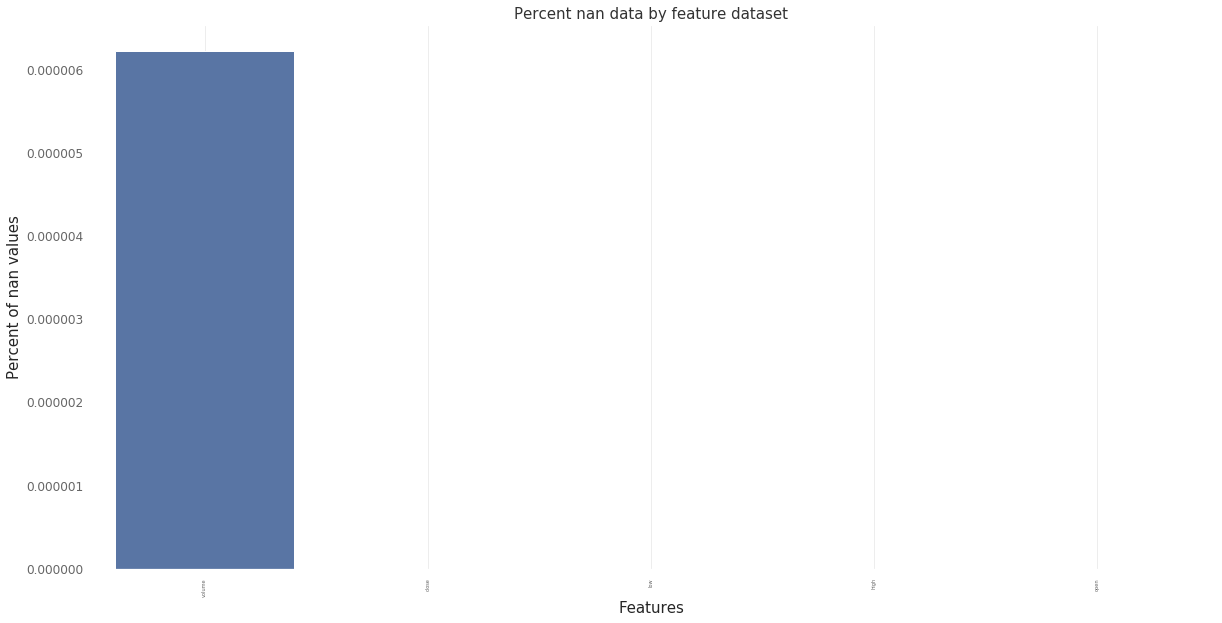

The percentage of dropped columns is 0%.
Dropped 0 columns out of 5


In [39]:
ohlcv = utils_s.cleaning_dataframe(ohlcv,0.2)

### 2 - 2 - 1 - Second universe filteration using Market Capitalization 

In [40]:
def dollar_volume_universe(tickers_num, ohlcv, sma_period):
    
    ohlcv['dollar_volume'] = ohlcv['close']*ohlcv['volume']
    dollar_vol = ohlcv['dollar_volume'].unstack('ticker')
    sma = pd.DataFrame(index = dollar_vol.index)
    try:
        for tick in dollar_vol.columns:
            sma[tick] = talib.SMA(dollar_vol[tick].values, timeperiod=sma_period)
    except:
        pass
    
    last = sma.iloc[-1,:]
    dol = pd.DataFrame(data = last.values,index = last.index, columns = ['dv'])
    dol.dropna(inplace = True)
    
    return list(dol.sort_values(by='dv', ascending=False).iloc[:tickers_num].index)    

In [41]:
universe = dollar_volume_universe(tickers_num = filteration_number, ohlcv = ohlcv, sma_period = smoothing_universe_period)

In [42]:
print ('{} companies selected out of {} for second filteration'.format(len(universe),len(u1)))

1000 companies selected out of 1985 for second filteration


#### Sector filteration

In [43]:
universe_sectors = pd.DataFrame(index=universe, columns=['sectors'])
for i in universe:
    universe_sectors.loc[i] = meta_ex_sc_cu.loc[i]['sector']
    
    for sec in sec_to_drop:
        if meta_ex_sc_cu.loc[i]['sector'] == sec:
            universe_sectors.drop(i, axis=0,inplace=True)

In [44]:
universe = list(universe_sectors.index)

In [45]:
print ('{} companies selected after sector drop out of {} for second filteration'.format(len(universe),len(u1)))

415 companies selected after sector drop out of 1985 for second filteration


## 2 - 3 - Get three years data for SF1

In [46]:
if update_data:
    #qopts={"columns":ind}
    quandl.export_table('SHARADAR/SF1',
                        ticker=universe, 
                        dimension = 'MRQ', 
                        calendardate={'gte':start_f,'lte':str(tod)}, 
                        filename='data/fundamental.zip')

We are generating the zip file now, please wait...
data/fundamental.zip


In [47]:
with zipfile.ZipFile('data/fundamental.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'SF1':
        sf1 = pd.read_csv(item)
        sf1 = sf1.set_index(['calendardate', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        sf1.drop(['datekey','reportperiod','lastupdated','dimension'],axis=1,inplace=True)
        os.remove(item)  

In [48]:
print ('the following tickers are not loaded in sf1:\n {}'.format(list(sf1.index.levels[1] ^ universe)))
print ('{} securities loaded out of {}'.format(len(sf1.index.levels[1]), len(universe)))

the following tickers are not loaded in sf1:
 ['BUD', 'CHKP', 'DOX', 'GDS', 'GLOB', 'INFY', 'MGA', 'MLCO', 'MTCH', 'NICE', 'STM', 'WB']
403 securities loaded out of 415


### 2 - 3 - 1 - Cleaning data

cleaning data
columns are clean


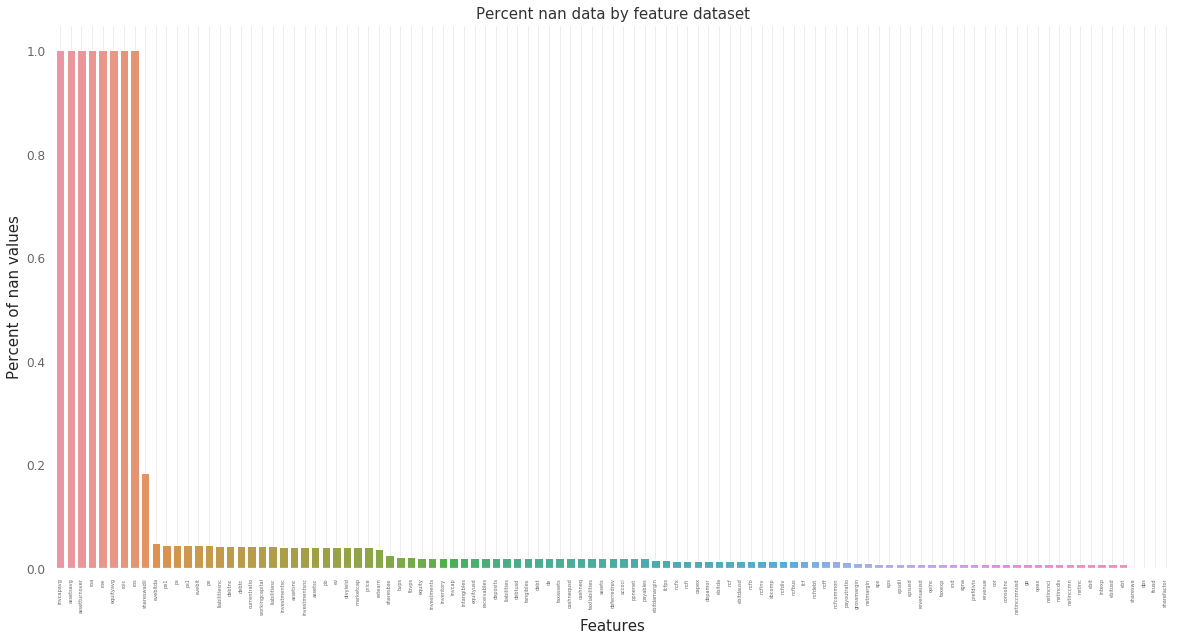

The percentage of dropped columns is 7%.
Dropped 8 columns out of 105


In [49]:
sf1 = utils_s.cleaning_dataframe(sf1,0.2)

In [50]:
sf1['roe'] = sf1['netinc'] / sf1['equity']
sf1['roa'] = sf1['netinc'] / sf1['assets']
sf1['fcf_yield'] = sf1['fcf'] / sf1['ev']

## 2 - 4 - Get two years data for DAILY

In [51]:
if update_data:
    quandl.export_table('SHARADAR/DAILY',
                        ticker=universe, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename='data/daily.zip')

We are generating the zip file now, please wait...
data/daily.zip


In [52]:


with zipfile.ZipFile('data/daily.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'DAILY':
        daily = pd.read_csv(item)
        daily['date'] = pd.to_datetime(daily['date'])
        daily = daily.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        daily.drop(['lastupdated'],axis=1,inplace=True)
        os.remove(item) 

cleaning data
columns are clean


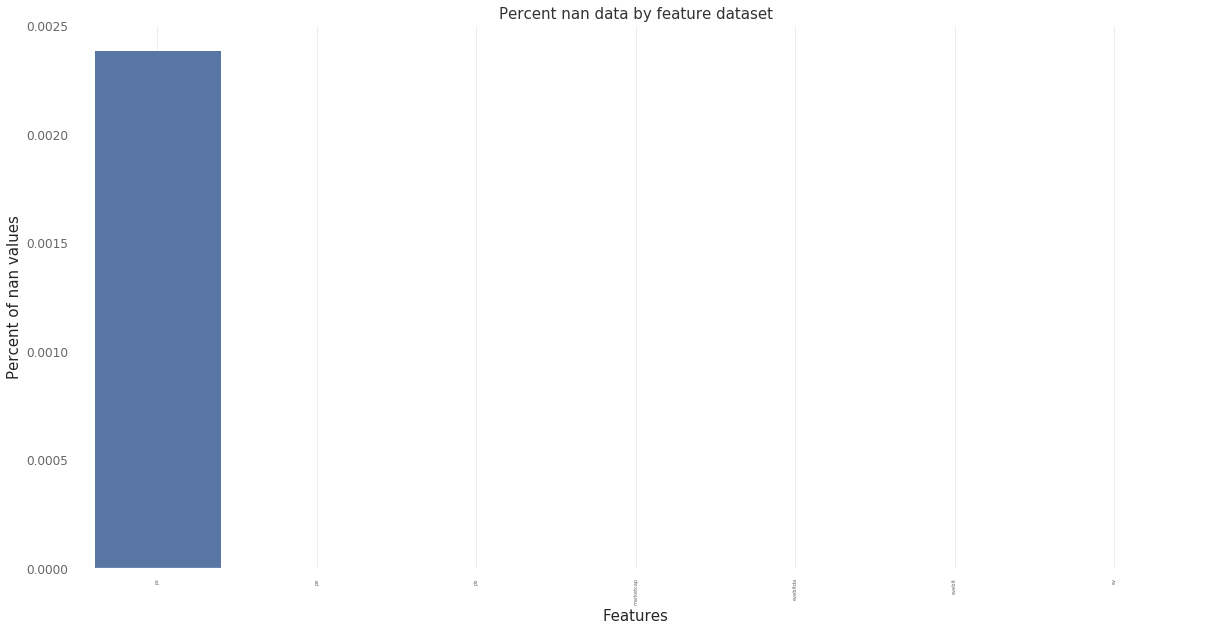

The percentage of dropped columns is 0%.
Dropped 0 columns out of 7


In [53]:
daily = utils_s.cleaning_dataframe(daily,0.2)

## 2 - 4 - Get two years data for SENTIMENT

In [54]:
if update_data:
    quandl.ApiConfig.api_key = 'WW4cUYaXdyxgjvdu4z9s'
    quandl.export_table('IFT/NSA',
                        ticker=universe, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename='data/sent.zip')

We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
data/sent.zip


In [55]:
with zipfile.ZipFile('data/sent.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'IFT' and item.split('_')[1] == 'NSA':
        sent = pd.read_csv(item)
        sent['date'] = pd.to_datetime(sent['date'])
        sent = sent.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        sent = sent[sent['exchange_cd']=='US']
        sent.drop(['name','exchange_cd'],axis=1,inplace=True)
        os.remove(item) 

cleaning data
columns are clean


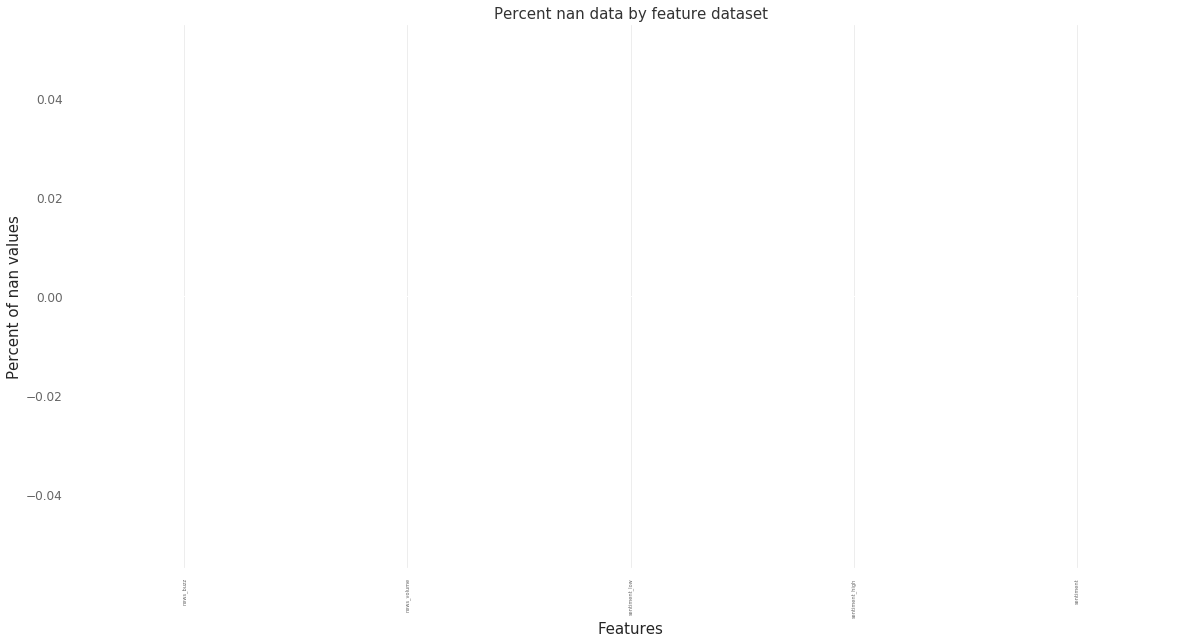

The percentage of dropped columns is 0%.
Dropped 0 columns out of 5


In [56]:
sent = utils_s.cleaning_dataframe(sent,0.2)

### Universe intersection

In [57]:
inter1 = set(sent['sentiment'].unstack('ticker').columns).intersection(set(sf1.index.levels[1]))
inter2 = inter1.intersection(set(daily.index.levels[1]))
inter3 = inter2.intersection(set(ohlcv.index.levels[1]))

new_universe = list(inter3)

In [58]:
len(new_universe)

374

# 3 - Sectors

In [59]:
meta_cleaned = meta_ex_sc_cu.loc[new_universe,:]

In [60]:
print ('Sectors in filtered data: \n')
sectors = {}
for i in set(meta_cleaned['sector']):
    print (' ',i)
    sectors[i] = list(meta_cleaned[meta_cleaned['sector'] == i].index)

Sectors in filtered data: 

  Technology
  Consumer Cyclical
  Consumer Defensive


# 4 - Factorizing, Neutralizing and Resampling 

## 4 - 1 - Factorizing

In [61]:
close = ohlcv['close'].unstack('ticker')[new_universe]
openn = ohlcv['open'].unstack('ticker')[new_universe]
high = ohlcv['high'].unstack('ticker')[new_universe]
low = ohlcv['low'].unstack('ticker')[new_universe]

In [62]:
#close.to_csv('close.csv')

In [63]:
pricing = openn.loc[slice(start,end),:].tz_localize('UTC')[new_universe]

In [64]:
# daily

daily_data = {}

for i in daily_in.keys():
    
    df_daily = daily[i].unstack('ticker')
    reversion = factorize.Momentum(df_daily,daily_in[i])*-1
    smoothed_reversion = factorize.Smooth(reversion,smoothed_value)
    smoothed_reversion.index = pd.to_datetime(smoothed_reversion.index)
    smoothed_reversion = smoothed_reversion.loc[slice(start,end),:]

    result = []
    for sec in sectors.keys():
        result.append(smoothed_reversion[sectors[sec]].sub(smoothed_reversion[sectors[sec]].mean(axis=1),axis=0))

    smoothed_reversion_neutralized = pd.concat(result,axis=1)
    smoothed_reversion_neutralized_scaled = pd.DataFrame(data = preprocessing.scale(smoothed_reversion_neutralized),
                                                         index = smoothed_reversion_neutralized.index,
                                                         columns = smoothed_reversion_neutralized.columns)
    
    daily_data[i] = smoothed_reversion_neutralized_scaled


In [65]:
# SMA
sma_data = {}

for name,period in sma_in.items():

    df= pd.DataFrame(index = close.index)

    try:
        for tick in close.columns:
            df[tick] = talib.SMA(close[tick].values, timeperiod=period)
    except:
        pass

    sma_min = (close - df)*-1
    smoothed_sma_min = factorize.Smooth(sma_min,smoothed_value)
    smoothed_sma_min.index = pd.to_datetime(smoothed_sma_min.index)
    smoothed_sma_min = smoothed_sma_min.loc[slice(start,end),:]
    
    # Neutralizing by sector
    result = []
    for sec in sectors.keys():
        result.append(smoothed_sma_min[sectors[sec]].sub(smoothed_sma_min[sectors[sec]].mean(axis=1),axis=0))

    smoothed_sma_min_neutralized = pd.concat(result,axis=1)    
    
    smoothed_sma_min_neutralized_scaled = pd.DataFrame(data = preprocessing.scale(smoothed_sma_min_neutralized),
                                                              index = smoothed_sma_min_neutralized.index,
                                                              columns = smoothed_sma_min_neutralized.columns)
    
    sma_data[name] = smoothed_sma_min_neutralized_scaled
    

In [66]:
over_data = {}

for name,period in over_in.items():
    overnight_sentiment = factorize.overnight_sentiment(close, openn, window_length=1, trailing_window=period)*-1
    smoothed_overnight_sentiment = factorize.Smooth(overnight_sentiment,smoothed_value)
    
    smoothed_overnight_sentiment.index = pd.to_datetime(smoothed_overnight_sentiment.index)
    
    smoothed_overnight_sentiment = smoothed_overnight_sentiment.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_overnight_sentiment[sectors[sec]].sub(smoothed_overnight_sentiment[sectors[sec]].mean(axis=1),axis=0))

    smoothed_overnight_sentiment_neutralized_scaled = pd.concat(result,axis=1)
    
    over_data[name] = smoothed_overnight_sentiment_neutralized_scaled
    

In [67]:
# mean reversion
momentum_data = {}

for name,period in momentum_in.items():
    
    mean_reversion = factorize.Momentum(close,period)*-1
    smoothed_mean_reversion = factorize.Smooth(mean_reversion,smoothed_value)
    
    smoothed_mean_reversion.index = pd.to_datetime(smoothed_mean_reversion.index)
    smoothed_mean_reversion = smoothed_mean_reversion.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_mean_reversion[sectors[sec]].sub(smoothed_mean_reversion[sectors[sec]].mean(axis=1),axis=0))

    smoothed_mean_reversion_neutralized_scaled = pd.concat(result,axis=1)
  
    momentum_data[name] = smoothed_mean_reversion_neutralized_scaled


In [68]:
# direction
direction_data = {}

for name,period in direction_in.items():
    
    direct = factorize.direction(close, openn, 1, period)
    smoothed_direct = factorize.Smooth(direct,smoothed_value)

    smoothed_direct.index = pd.to_datetime(smoothed_direct.index)
    smoothed_direct = smoothed_direct.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_direct[sectors[sec]].sub(smoothed_direct[sectors[sec]].mean(axis=1),axis=0))

    smoothed_direct_neutralized_scaled = pd.concat(result,axis=1)
    
    direction_data[name] = smoothed_direct_neutralized_scaled

In [69]:
# sentiment
sent_data = {}

for name,period in sent_in.items():
    
    sentiment = factorize.sentiment(close, high, low, sent, period, new_universe)
    smoothed_sentiment= factorize.Smooth(sentiment,smoothed_value)
    smoothed_sentiment.index = pd.to_datetime(smoothed_sentiment.index)
    smoothed_sentiment = smoothed_sentiment.loc[slice(start,end),:]
    
    to_drop = smoothed_sentiment.columns ^ close.columns

    for i in to_drop:
        sectors[meta_cleaned.loc[i]['sector']].remove(i)
        
    result = []
    for sec in sectors.keys():
        result.append(smoothed_sentiment[sectors[sec]].sub(smoothed_sentiment[sectors[sec]].mean(axis=1),axis=0))
    
    smoothed_sentiment_neutralized_scaled = pd.concat(result,axis=1)
    
    sent_data[name] = smoothed_sentiment_neutralized_scaled

## 4 - 2 - Fundamentals 

### 4 - 2 - 1 - Indicators

In [70]:
#indicator=ind
indicators_desc = quandl.get_table('SHARADAR/INDICATORS')
sf1_ind = indicators_desc[indicators_desc['table']=='SF1']

In [71]:
# Columns description of cleaned SF1
for i in sf1.columns:
    try:
        print (i,':',sf1_ind[sf1_ind['indicator']==i]['title'].values[0],':',sf1_ind[sf1_ind['indicator']==i]['description'].values[0],'\n')
    except:
        pass

accoci : Accumulated Other Comprehensive Income : [Balance Sheet] A component of [Equity] representing the accumulated change in equity from transactions and other events and circumstances from non-owner sources; net of tax effect; at period end. Includes foreign currency translation items; certain pension adjustments; unrealized gains and losses on certain investments in debt and equity securities. 

assets : Total Assets : [Balance Sheet] Sum of the carrying amounts as of the balance sheet date of all assets that are recognized. Major components are [CashnEq]; [Investments];[Intangibles]; [PPNENet];[TaxAssets] and [Receivables]. 

assetsc : Current Assets : [Balance Sheet] The current portion of [Assets]; reported if a company operates a classified balance sheet that segments current and non-current assets. 

assetsnc : Assets Non-Current : [Balance Sheet] Amount of non-current assets; for companies that operate a classified balance sheet. Calculated as the different between Total As

sps : Sales per Share : [Metrics] Sales per Share measures the ratio between [RevenueUSD] and [SharesWA] as adjusted by [ShareFactor]. 

tangibles : Tangible Asset Value : [Metrics] The value of tangibles assets calculated as the difference between [Assets] and [Intangibles]. 

taxassets : Tax Assets : [Balance Sheet] A component of [Assets] representing tax assets and receivables. 

taxexp : Income Tax Expense : [Income Statement] Amount of current income tax expense (benefit) and deferred income tax expense (benefit) pertaining to continuing operations. 

taxliabilities : Tax Liabilities : [Balance Sheet] A component of [Liabilities] representing outstanding tax liabilities. 

tbvps : Tangible Assets Book Value per Share : [Metrics] Measures the ratio between [Tangibles] and [SharesWA] as adjusted by [ShareFactor]. 

workingcapital : Working Capital : [Metrics] Working capital measures the difference between [AssetsC] and [LiabilitiesC]. 

roe : Return on Average Equity : [Metrics] R

### 4 - 2 - 2 - Factorizing, Neutralizing and Resampling

In [72]:
data = {}
for i in selected_indicators:
    
    df = sf1[i].unstack('ticker')[new_universe]
    df.fillna(df.mean(axis=0),inplace=True)
    
    # Calculating Return
    returns = factorize.Returns(df,window_length=1)
    returns.replace([np.inf, -np.inf], np.nan, inplace=True)    
    
    returns_drz = pd.DataFrame(data = preprocessing.scale(returns),
                               index = returns.index,
                               columns = returns.columns) 

    result = []
    for sec in sectors.keys():
        result.append(returns_drz[sectors[sec]].sub(returns[sectors[sec]].mean(axis=1),axis=0))
    
    returns_neutralize = pd.concat(result,axis=1)

    # Resampling
    chunk = (ohlcv.index.levels[0][-1]+datetime.timedelta(days=1)).date()
    chunk_minus = ohlcv.index.levels[0][-1].date()
    returns_neutralize.loc[chunk,:] = np.nan
    returns_neutralize.index = pd.to_datetime(returns_neutralize.index)
    returns_neutralize_resampled = returns_neutralize.resample('D').pad()
    returns_neutralize_resampled = returns_neutralize_resampled.loc[start_sep:chunk_minus,:]
    
    # Drop holidays
    holidays = returns_neutralize_resampled.index ^ ohlcv.index.levels[0]
    returns_neutralize_resampled.drop(list(holidays),axis=0,inplace = True)
    returns_neutralize_resampled.index.name = ohlcv.index.levels[0].name
    
    # Slicing 1 year
    returns_neutralize_resampled_1y = returns_neutralize_resampled.loc[slice(start,end),:]

    data[i] = returns_neutralize_resampled_1y

## 4 - 4 - Multiindex factors

In [73]:
result = []

for ind in selected_indicators:
    
    fund_return_neutralized_stacked = data[ind].stack().to_frame(ind)
    result.append(fund_return_neutralized_stacked)

for i in daily_in.keys():

    daily_stacked = daily_data[i].stack().to_frame('daily_{}{}days'.format(i,daily_in[i]))
    result.append(daily_stacked)

for i in sma_data.keys():

    sma_stacked = sma_data[i].stack().to_frame('sma{}'.format(sma_in[i]))
    result.append(sma_stacked)

for i in momentum_data.keys():
    
    momentum_stacked = momentum_data[i].stack().to_frame('momentum{}days'.format(momentum_in[i]))
    result.append(momentum_stacked)
    
for i in over_data.keys():
    
    over_stacked = over_data[i].stack().to_frame('overnight_sent{}days'.format(over_in[i]))
    result.append(over_stacked)    

for i in direction_data.keys():
    
    direct_stacked = direction_data[i].stack().to_frame('direction{}days'.format(direction_in[i]))
    result.append(direct_stacked)

for i in sent_data.keys():
    
    sent_stacked = sent_data[i].stack().to_frame('sentiment{}days'.format(sent_in[i]))
    result.append(sent_stacked)    
    
all_factors = pd.concat(result,axis=1)

all_factors.index = all_factors.index\
                               .set_levels([all_factors.index.levels[0].tz_localize('UTC'), all_factors.index.levels[1]])
#all_factors.dropna(axis=0, inplace = True)
all_factors

cashneq  daily_marketcap100days  \
date                      ticker                                     
2019-07-15 00:00:00+00:00 MCHP    0.144356                0.693467   
                          BKI     0.127625               -0.674276   
                          FTV    -3.290515               -0.586828   
                          NTNX   -0.152679                2.165631   
                          CHNG    0.328511                0.371458   
                          INTC    0.060903                1.217592   
                          AVGO    0.043120                0.613354   
                          TER     0.142229                1.023597   
                          IBM     0.889483               -0.142237   
                          HQY     0.800432                1.239387   
                          SE      0.295497               -0.483596   
                          AMAT   -0.074085                0.806316   
                          JNPR   -2.772918               -0.635093   
                          NEWR    0.103328               -0.057012   
                          ADSK    0.481118                0.144975   
                          LRCX   -0.483188                1.692886   
                          KLAC   -0.327218                0.248652   
                          NLOK    0.161951               -0.307634   
                          CSCO    0.435177               -1.979939   
                          CTXS   -3.216896                1.798497   
                          ADI     0.105662               -0.825677   
                          CDW    -0.469845               -0.537829   
                          FSLR    0.574037               -1.615989   
                          SNAP    0.689071               -0.535946   
                          CIEN    0.440553                0.378575   
                          IIVI   -0.344695                1.988277   
                          LOGM   -0.964249                1.772172   
                          DELL    0.122678                2.612538   
                          FB      0.659282               -1.938387   
                          CRUS   -0.175109                0.852992   
...                                    ...                     ...   
2020-07-14 00:00:00+00:00 WMT    -1.399298               -1.158158   
                          COTY   -1.436734                2.150208   
                          POST    0.965283                1.331469   
                          HSY    -2.222112                1.913998   
                          NWL     1.639388                0.505026   
                          BG      2.257076                0.991780   
                          CPB    -0.989559                0.391672   
                          LW      1.325284                1.785760   
                          K      -2.576642                0.092643   
                          HRL     0.134286                0.242887   
                          PG     -1.678988                0.141545   
                          TAP     1.219013                2.712601   
                          CLX     0.826655               -1.551915   
                          MDLZ   -0.595282                2.214574   
                          DLTR   -1.173637               -1.235272   
                          DG     -3.013875               -0.590183   
                          CAG     1.950207               -1.362800   
                          PFGC   -0.759412                1.977758   
                          MNST    0.220193               -0.187222   
                          INGR    2.216888                0.939739   
                          COST    2.360676                0.969022   
                          SAM     0.946500               -1.370526   
                          STZ     2.875537                0.172291   
                          HLF     1.487363               -1.897945   
                          GIS     2.446302   

In [74]:
all_factors.isna().sum()

cashneq                   0
daily_marketcap100days    0
daily_evebitda100days     0
sma200                    0
momentum252days           0
overnight_sent5days       0
direction100days          0
sentiment100days          0
dtype: int64

# 5 - All factors analysis

In [75]:
print ('Rebalance period set to {} days for factor analysis'.format(rebalance_period))

Rebalance period set to 5 days for factor analysis


In [76]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, 
                                                          prices=pricing, 
                                                          periods=[rebalance_period], 
                                                          quantiles=5,
                                                          filter_zscore=20,
                                                          max_loss=0.35)
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% en

### 5 - 1 - Cumulated factor return

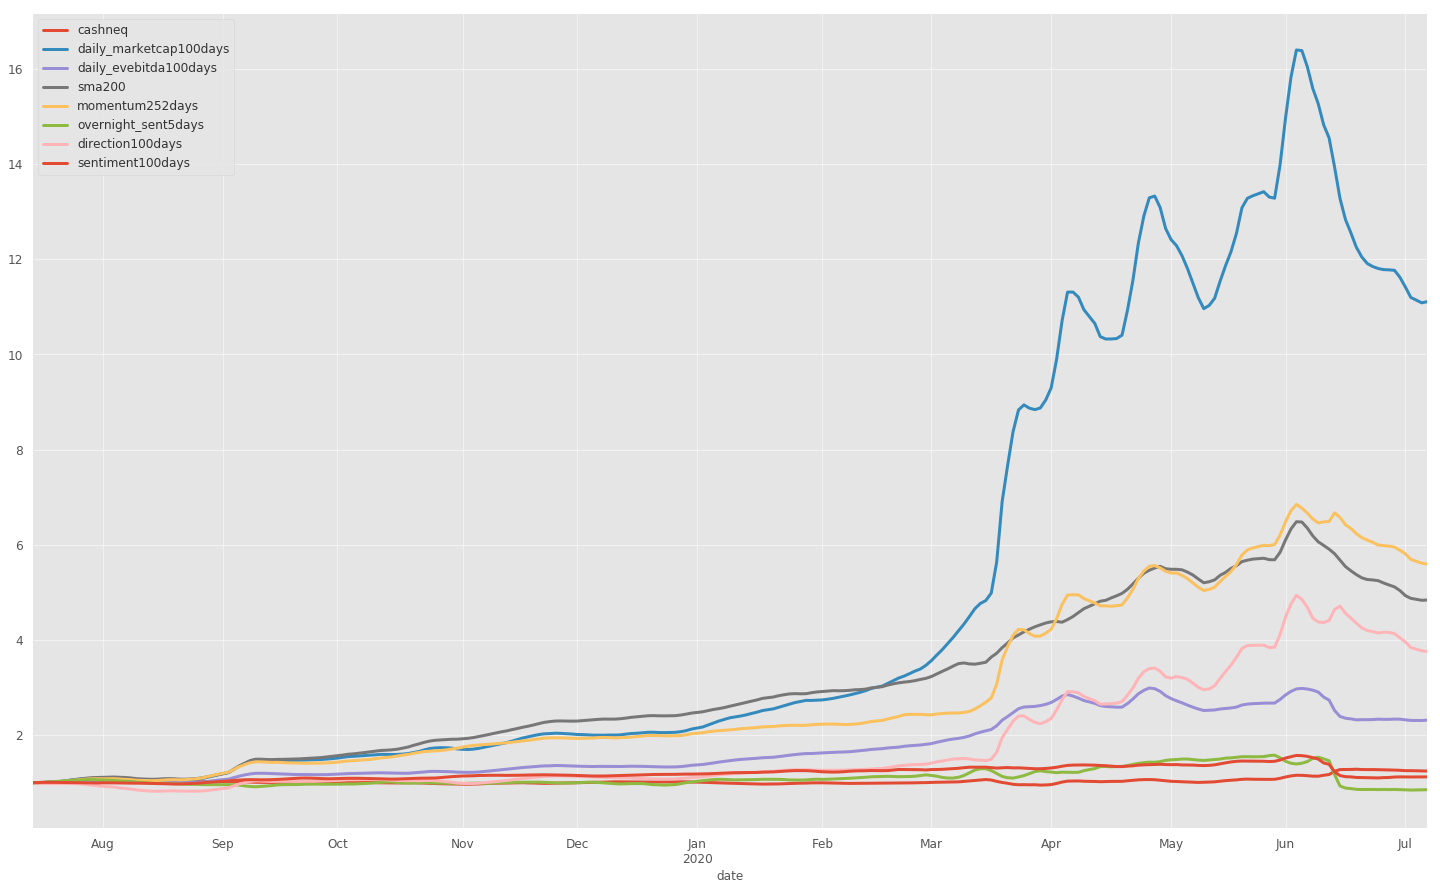

In [77]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (25, 15)

ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot(lw=3);

### 5 - 2 - Quantile analysis

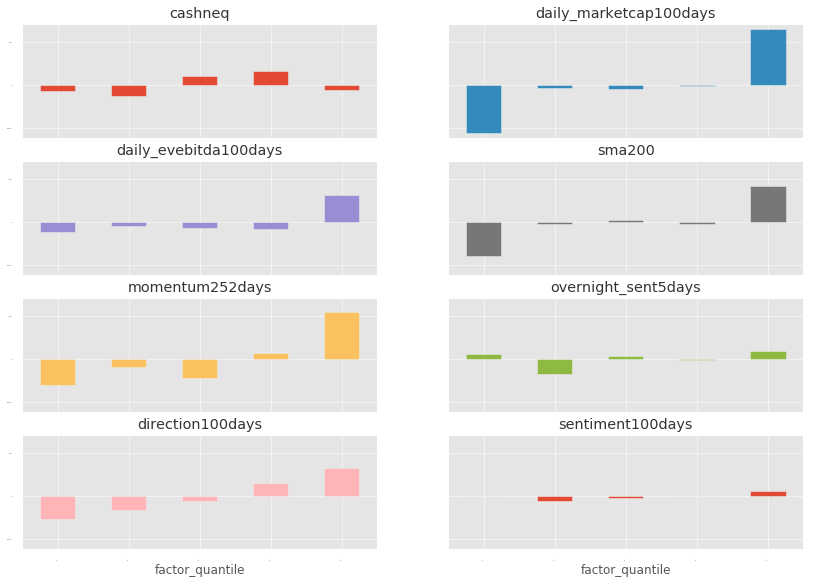

In [78]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(20,2),
    figsize=(14, 50),
    legend=False, fontsize=2);

### 5 - 3 - Factor Rank Autocorrelation

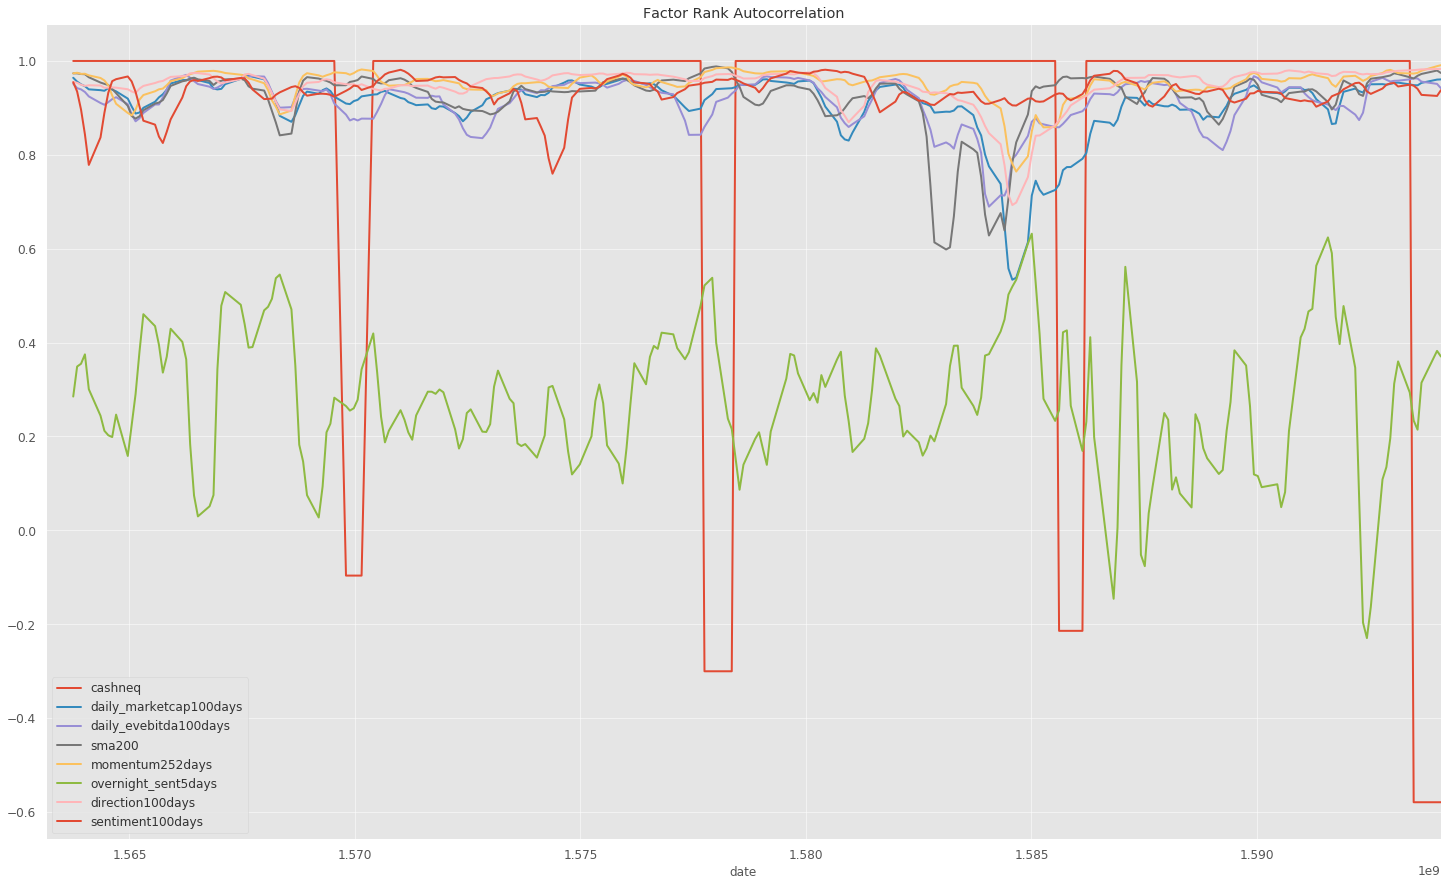

In [79]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data,period=rebalance_period)

ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

### 5 - 4 - Sharpe ratio

In [80]:
def sharpe_ratio(factor_returns, annualization_factor):

    df_sharpe = pd.Series(annualization_factor*factor_returns.mean()/factor_returns.std())
    
    return df_sharpe

In [81]:
daily_annualization_factor = np.sqrt(252)
df_sharpe = sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

In [82]:
df_sharpe.sort_values(ascending=False)

sma200                    8.75
daily_marketcap100days    6.13
momentum252days           6.05
daily_evebitda100days     4.26
direction100days          3.62
cashneq                   1.95
sentiment100days          0.79
overnight_sent5days      -0.25
dtype: float64

# 6 - Combined Alpha Factors

## 6 - 1 - Combining selceted factors

In [83]:

selected_factors = [
                         'sma200',
                         'daily_marketcap100days',
                         'direction100days',
                         'momentum252days',
                         'sentiment100days',
                         'cashneq'
                   ]

print('Selected Factors:\n{} '.format(',\n'.join(selected_factors)))

all_factors = all_factors[selected_factors]

Selected Factors:
sma200,
daily_marketcap100days,
direction100days,
momentum252days,
sentiment100days,
cashneq 


Time to train full ML pipline: 1.5588006973266602 secs
Accuracy on train set = 50.74%
Predictions: [-1. -1. -1. ... -1. -1. -1.]
Probabilities of class == 1: [49.9998905 49.9998905 49.9998905 ... 49.9998905 49.9998905 49.9998905]
Accuracy on test set = 50.00%
Log-loss = 0.69315


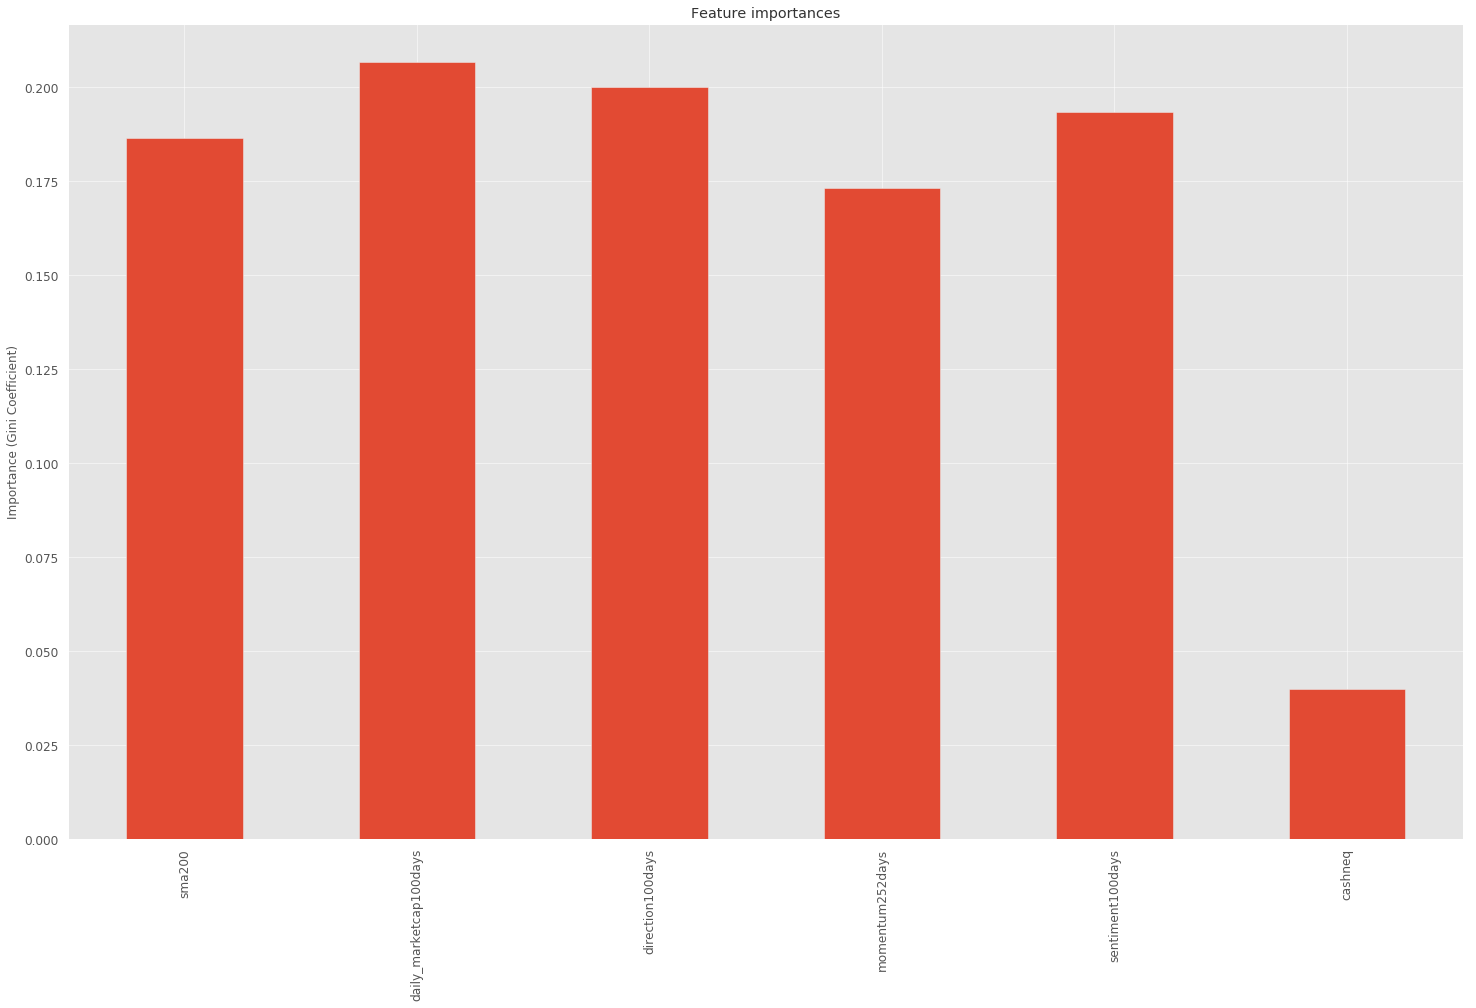

In [84]:
feature_importances = feature_weights.feature_importance(n_fwd_days = rebalance_period, 
                                                         close = close, 
                                                         all_factors = all_factors)

In [85]:
feature_importances

weights
factors                         
sma200                  0.186667
daily_marketcap100days  0.206667
direction100days        0.200000
momentum252days         0.173333
sentiment100days        0.193333
cashneq                 0.040000

In [86]:
all_factors_copy = all_factors.copy() 

In [87]:
for factor in selected_factors:
    all_factors_copy.loc[:,factor] = feature_importances.loc[factor][0] * all_factors.loc[:,factor]
all_factors_copy.loc[:,'alpha_vector'] = all_factors.sum(axis=1)
all_factors = all_factors_copy  

In [88]:
vec = pd.DataFrame(data=all_factors['alpha_vector'],columns = ['alpha_vector','sector'])
for date in vec.index.levels[0]:
    vec.loc[date,['sector']] = meta_ex_sc_cu.loc[vec.index.levels[1]]['sector'].values
sectors = vec['sector']

In [89]:
vec.shape

(94622, 2)


## 6 - 2 - Creating clean factor data

In [90]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor = all_factors['alpha_vector'], 
                                                          prices = pricing, 
                                                          periods = combined_periods,
                                                          quantiles = qunatile_portions,
                                                          groupby=sectors,
                                                          binning_by_group=False,
                                                          filter_zscore=20,
                                                          max_loss=0.15)

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 15.0%, not exceeded: OK!


## 6 - 3 - Creating tear sheets 

In [91]:
pf_returns, pf_positions, pf_benchmark = \
al.performance.create_pyfolio_input(factor_data,
                                       period='{}D'.format(rebalance_period),
                                       capital=10000,
                                       long_short=True,
                                       group_neutral=False,
                                       equal_weight=False,
                                       #quantiles=[1,2,4,5],
                                       groups=sectors,
                                       benchmark_period='{}D'.format(rebalance_period))

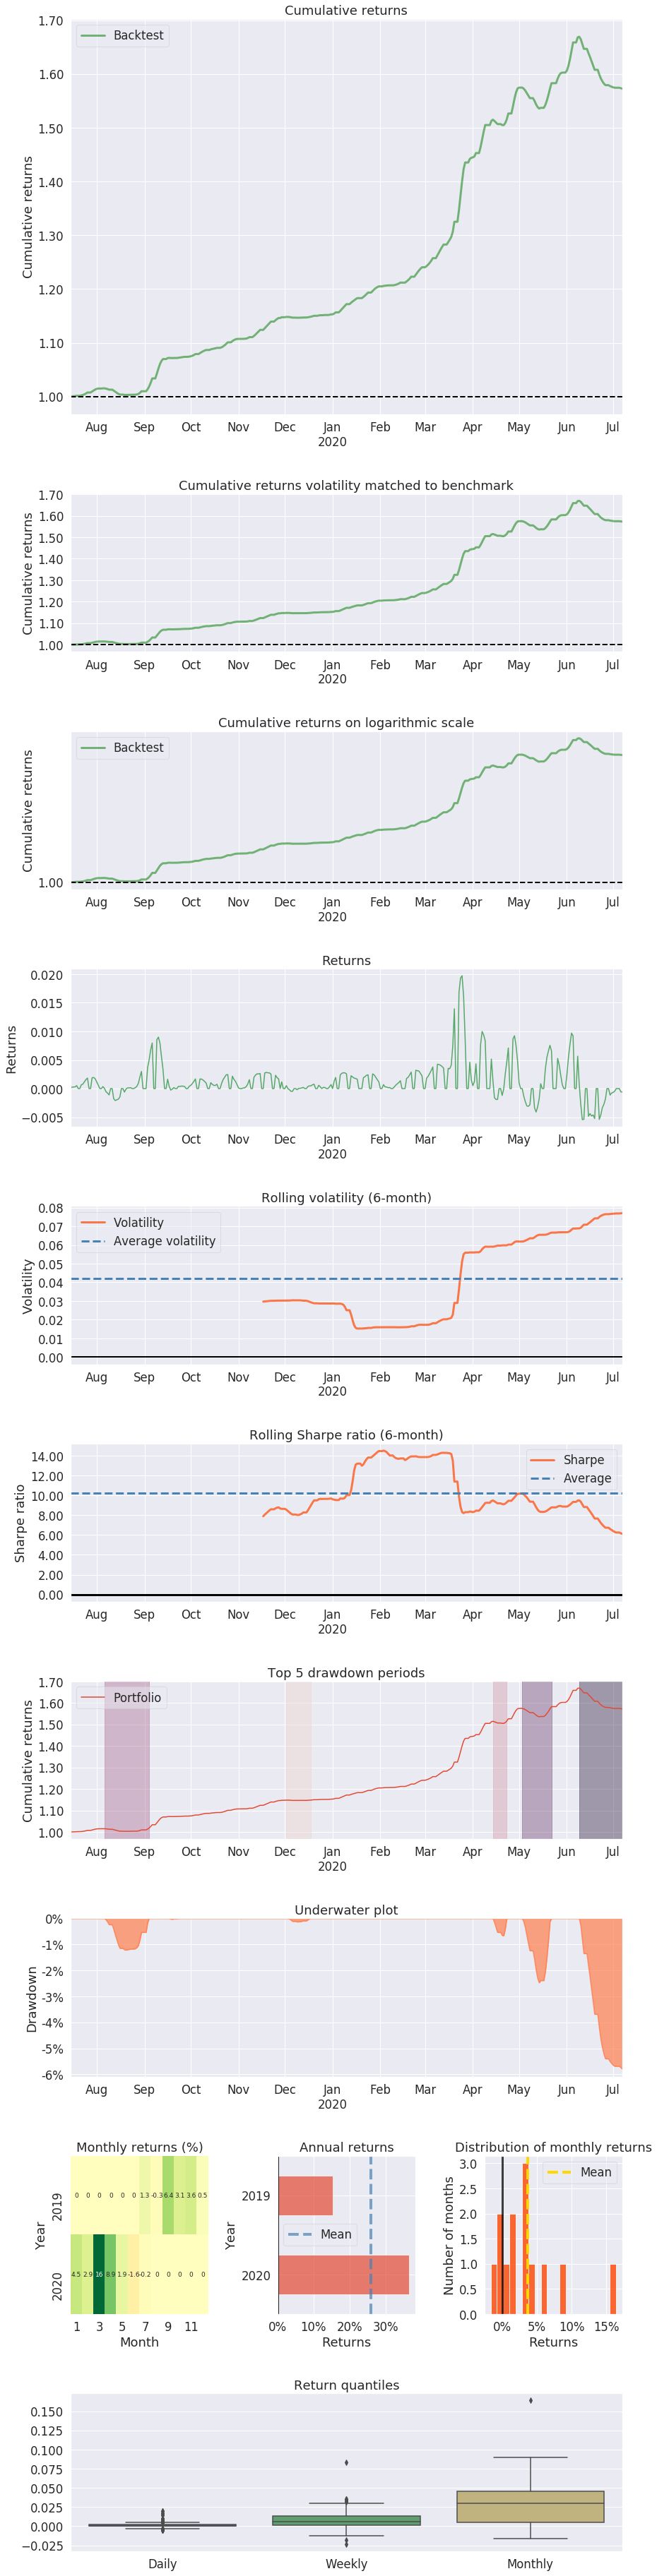

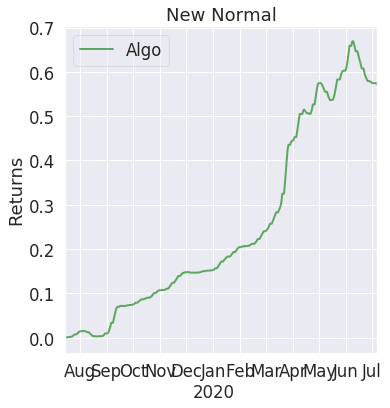

In [92]:
pf.create_full_tear_sheet(pf_returns)

Quantiles Statistics


min        max      mean       std  count   count %
factor_quantile                                                           
1               -13.483815  -3.993272 -6.206381  1.287240   3645  4.010695
2                -8.197852  -2.819412 -4.649491  0.893459   3645  4.010695
3                -7.315608  -2.321469 -3.890819  0.817917   3645  4.010695
4                -6.365509  -1.860522 -3.319160  0.766481   3645  4.010695
5                -5.693339  -1.515659 -2.845302  0.714463   3645  4.010695
6                -4.956750  -1.209350 -2.412720  0.631109   3645  4.010695
7                -4.455025  -0.935189 -2.019150  0.550533   3645  4.010695
8                -4.091355  -0.648404 -1.642671  0.483104   3645  4.010695
9                -3.614881  -0.401368 -1.291036  0.428593   3645  4.010695
10               -2.926394  -0.156121 -0.948749  0.387107   3645  4.010695
11               -2.425029   0.254389 -0.606879  0.368807   3645  4.010695
12               -1.787061   0.726816 -0.265247  0.362909   3645  4.010695
13               -1.386424   1.189926  0.074283  0.389464   3402  3.743316
14               -0.912554   1.603949  0.403433  0.420270   3645  4.010695
15               -0.424524   2.066760  0.741533  0.453499   3645  4.010695
16                0.009110   2.460622  1.090875  0.483331   3645  4.010695
17                0.415187   3.059809  1.454811  0.504931   3645  4.010695
18                0.861726   3.563116  1.843647  0.521487   3645  4.010695
19                1.318111   4.398843  2.269823  0.557689   3645  4.010695
20                1.715726   4.898044  2.731128  0.600258   3645  4.010695
21                2.100748   5.654606  3.233225  0.647892   3645  4.010695
22                2.580034   6.518527  3.779474  0.704334   3645  4.010695
23                3.111779   7.426366  4.443416  0.805108   3645  4.010695
24                3.618390   8.218852  5.251167  0.901914   3645  4.010695
25                4.292170  14.898137  6.910468  1.511718   3645  4.010695

Returns Analysis


3D       5D      10D
Ann. alpha                                       0.563    0.547    0.506
beta                                             0.232    0.197    0.049
Mean Period Wise Return Top Quantile (bps)     145.557  137.219  116.517
Mean Period Wise Return Bottom Quantile (bps)  -92.527  -92.084  -79.068
Mean Period Wise Spread (bps)                  238.084  228.043  193.807

<Figure size 1800x1080 with 0 Axes>

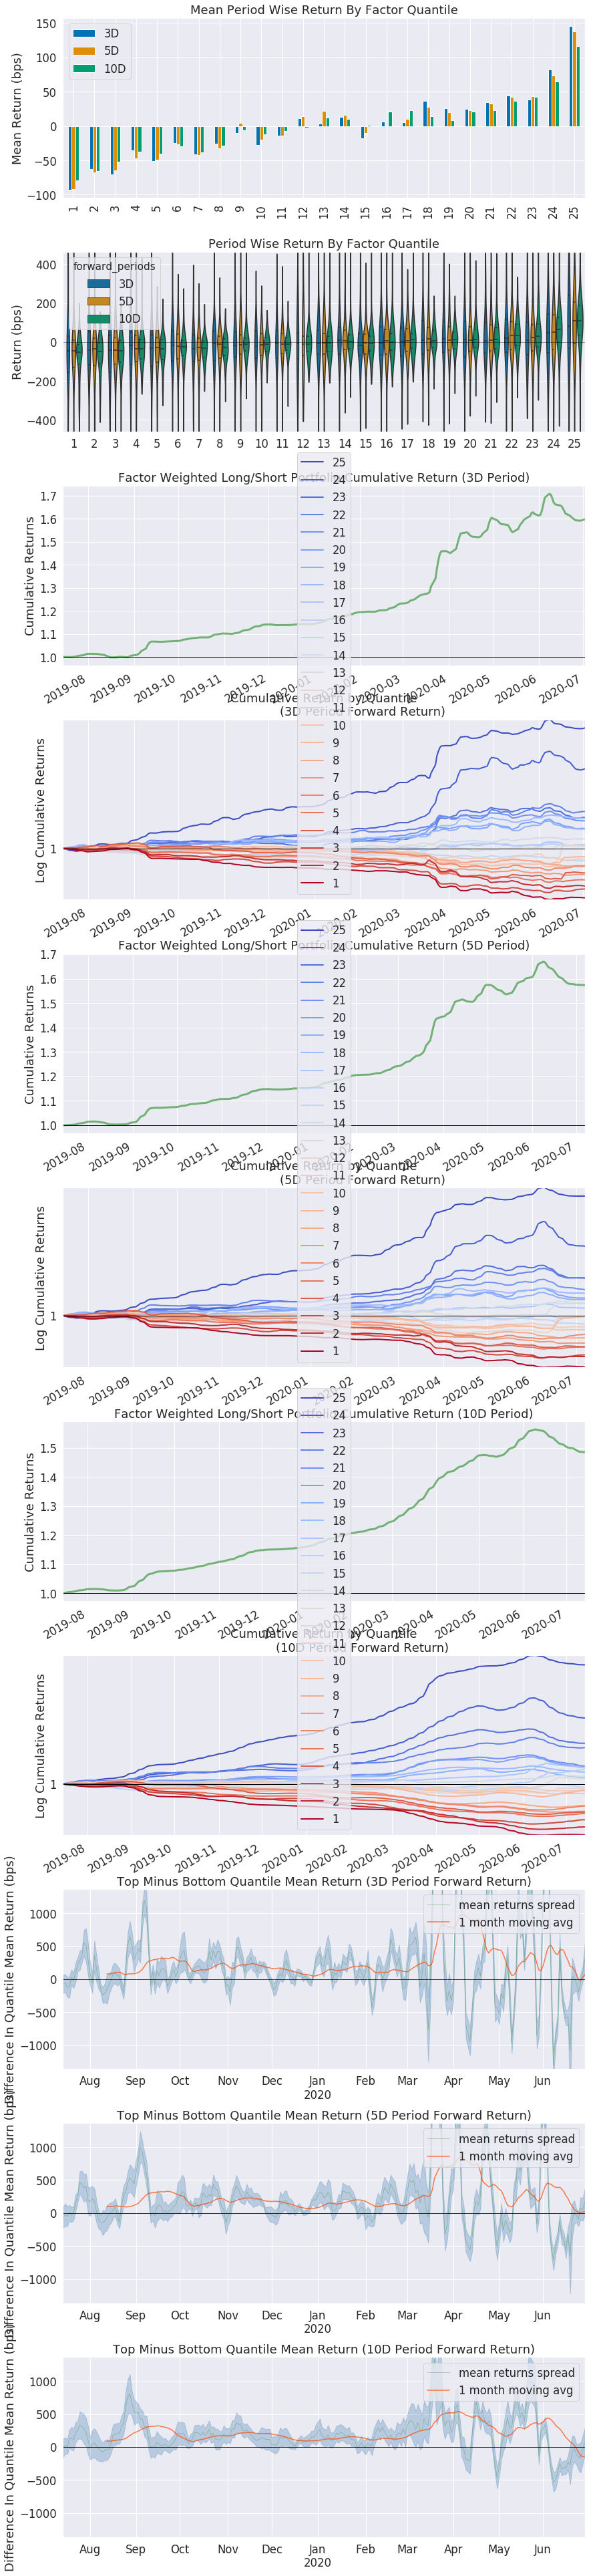

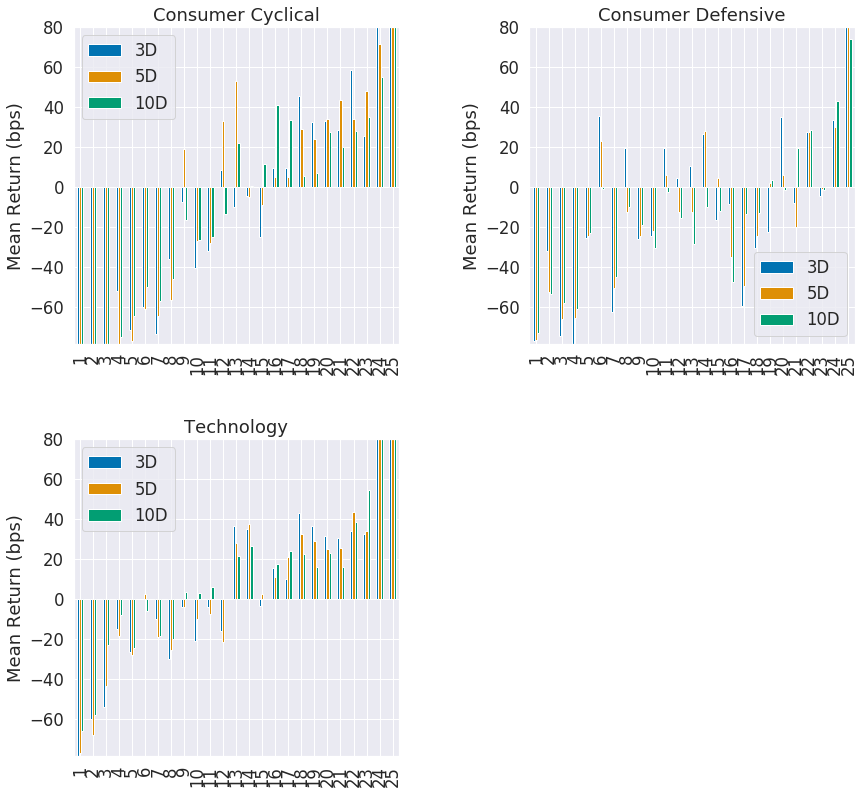

Information Analysis


3D     5D    10D
IC Mean           0.067  0.091  0.139
IC Std.           0.207  0.216  0.224
Risk-Adjusted IC  0.326  0.419  0.620
t-stat(IC)        5.086  6.533  9.661
p-value(IC)       0.000  0.000  0.000
IC Skew          -0.026 -0.044 -0.575
IC Kurtosis       0.210  0.027  0.120

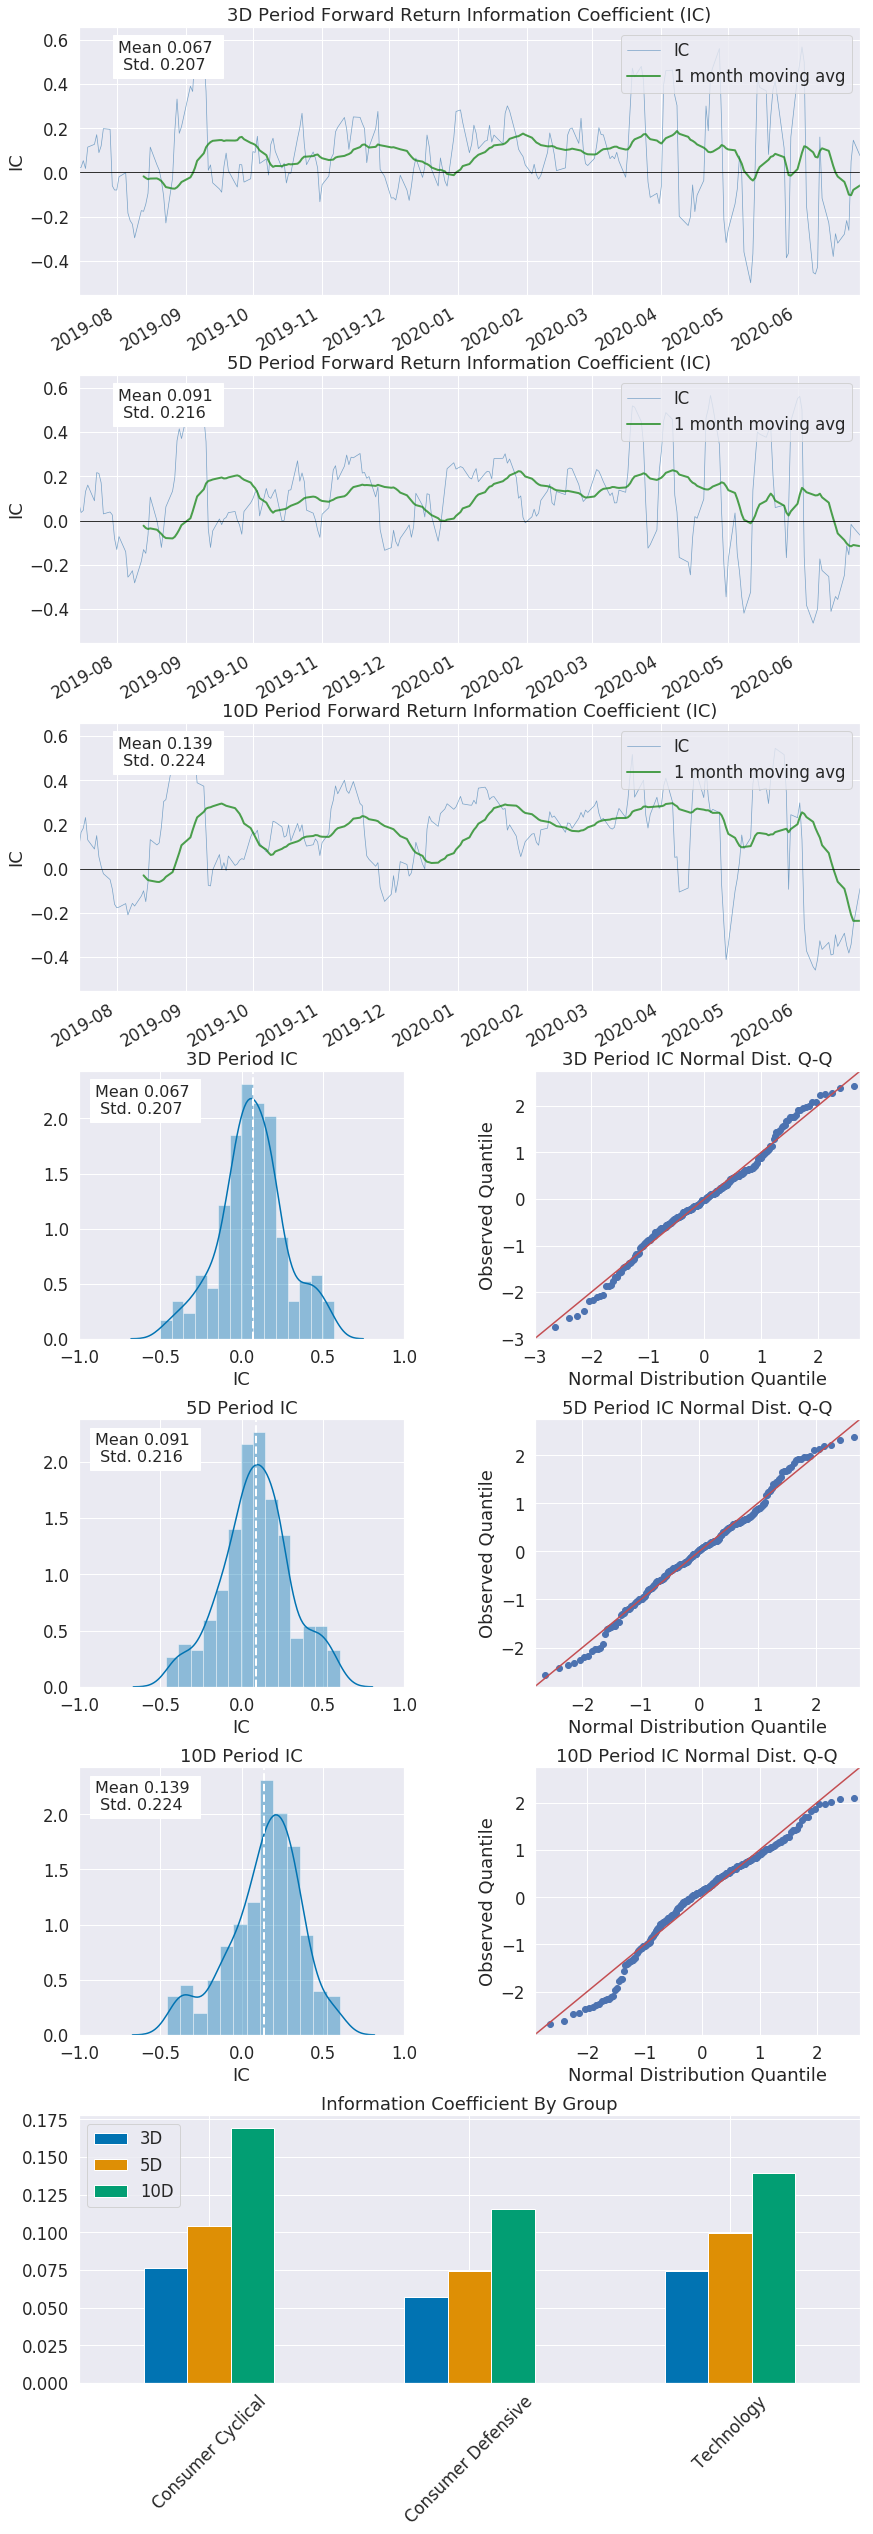

Turnover Analysis


10D     3D     5D
Quantile 1 Mean Turnover    0.474  0.222  0.320
Quantile 2 Mean Turnover    0.753  0.488  0.614
Quantile 3 Mean Turnover    0.819  0.600  0.711
Quantile 4 Mean Turnover    0.851  0.656  0.760
Quantile 5 Mean Turnover    0.864  0.710  0.799
Quantile 6 Mean Turnover    0.879  0.721  0.816
Quantile 7 Mean Turnover    0.897  0.747  0.829
Quantile 8 Mean Turnover    0.896  0.761  0.838
Quantile 9 Mean Turnover    0.912  0.770  0.846
Quantile 10 Mean Turnover   0.906  0.784  0.844
Quantile 11 Mean Turnover   0.911  0.785  0.858
Quantile 12 Mean Turnover   0.910  0.783  0.854
Quantile 13 Mean Turnover   0.928  0.813  0.876
Quantile 14 Mean Turnover   0.913  0.788  0.849
Quantile 15 Mean Turnover   0.902  0.787  0.853
Quantile 16 Mean Turnover   0.908  0.769  0.853
Quantile 17 Mean Turnover   0.910  0.773  0.847
Quantile 18 Mean Turnover   0.894  0.754  0.839
Quantile 19 Mean Turnover   0.886  0.726  0.822
Quantile 20 Mean Turnover   0.882  0.712  0.803
Quantile 21 Mean Turnover   0.874  0.707  0.803
Quantile 22 Mean Turnover   0.862  0.675  0.771
Quantile 23 Mean Turnover   0.835  0.617  0.744
Quantile 24 Mean Turnover   0.757  0.510  0.643
Quantile 25 Mean Turnover   0.516  0.241  0.351

3D     5D    10D
Mean Factor Rank Autocorrelation  0.964  0.924  0.829

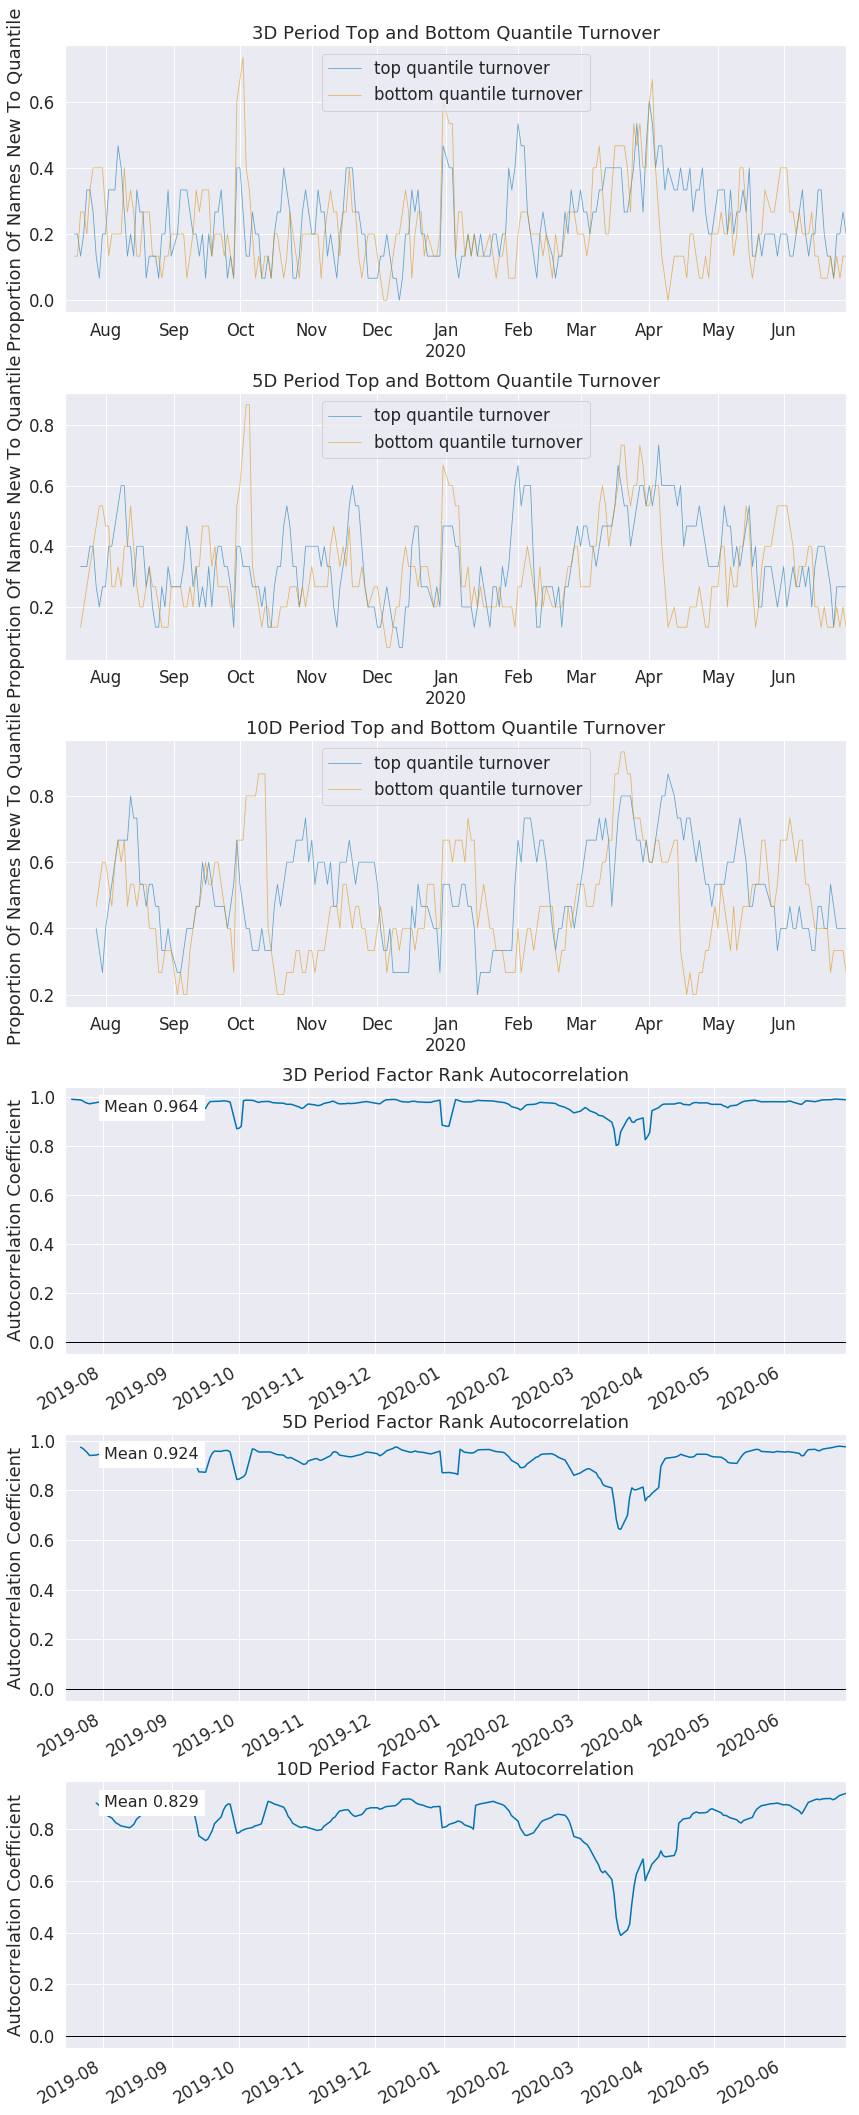

In [93]:
al.tears.create_full_tear_sheet(factor_data, by_group=True, long_short=True, group_neutral=False);

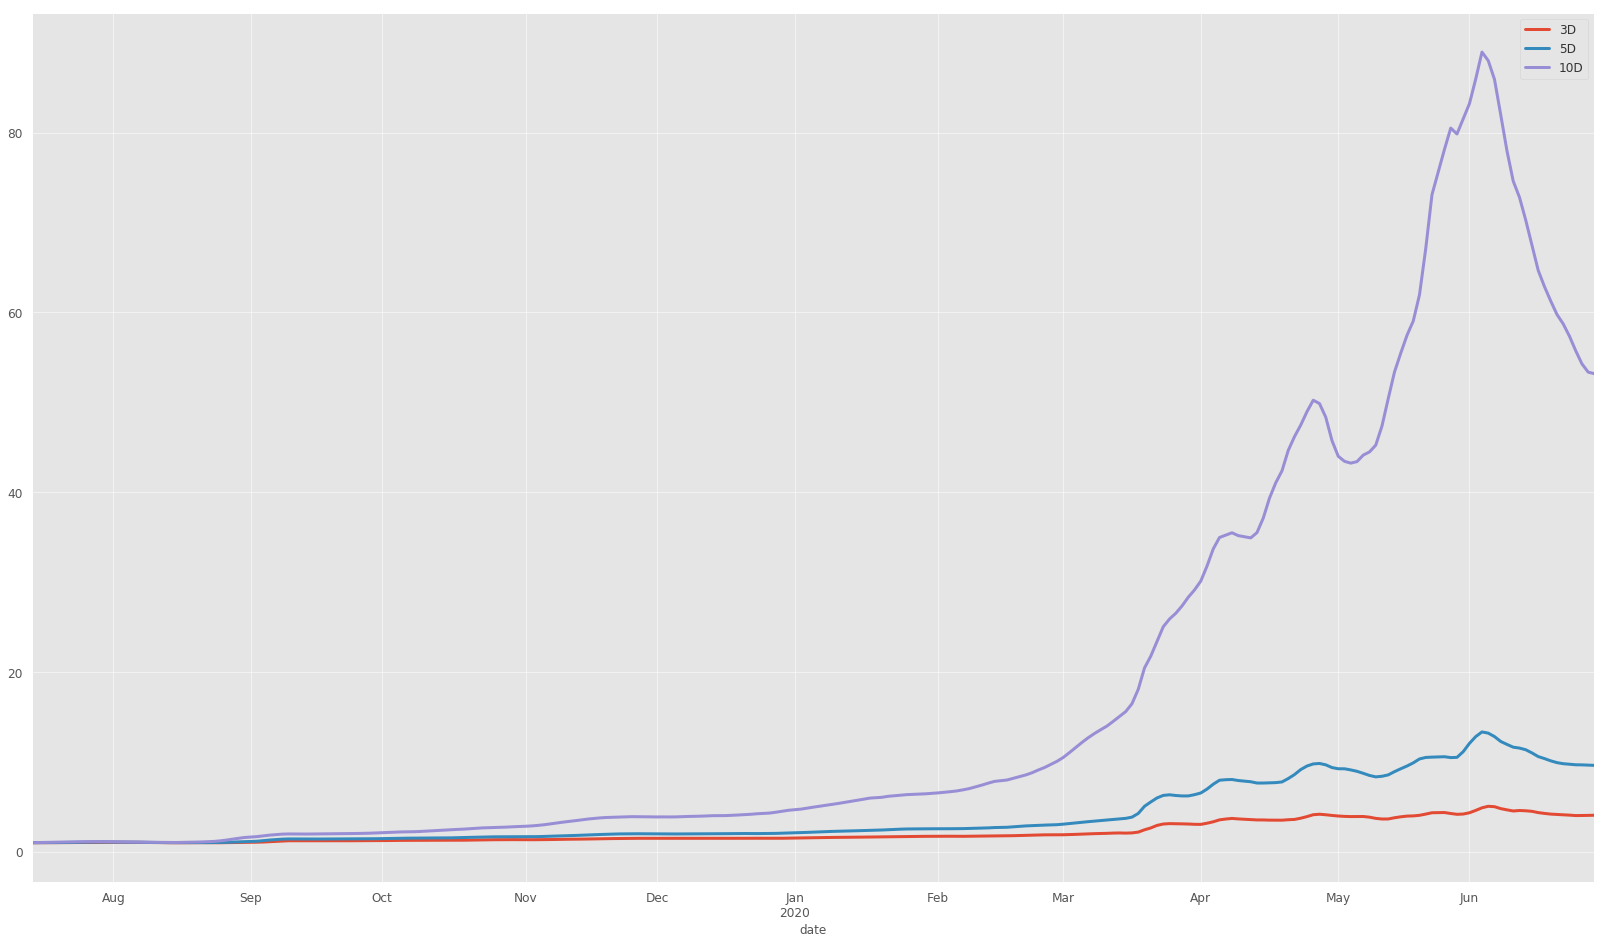

In [94]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (28, 16)

ls_factor_returns = al.performance.factor_returns(factor_data)

(1+ls_factor_returns).cumprod().plot(lw=3);

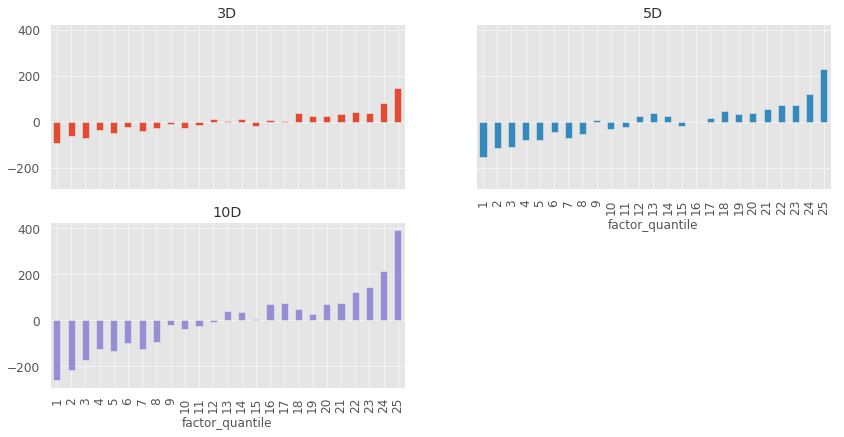

In [95]:
qr_factor_returns = pd.DataFrame()

qr_factor_returns = al.performance.mean_return_by_quantile(factor_data)[0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);

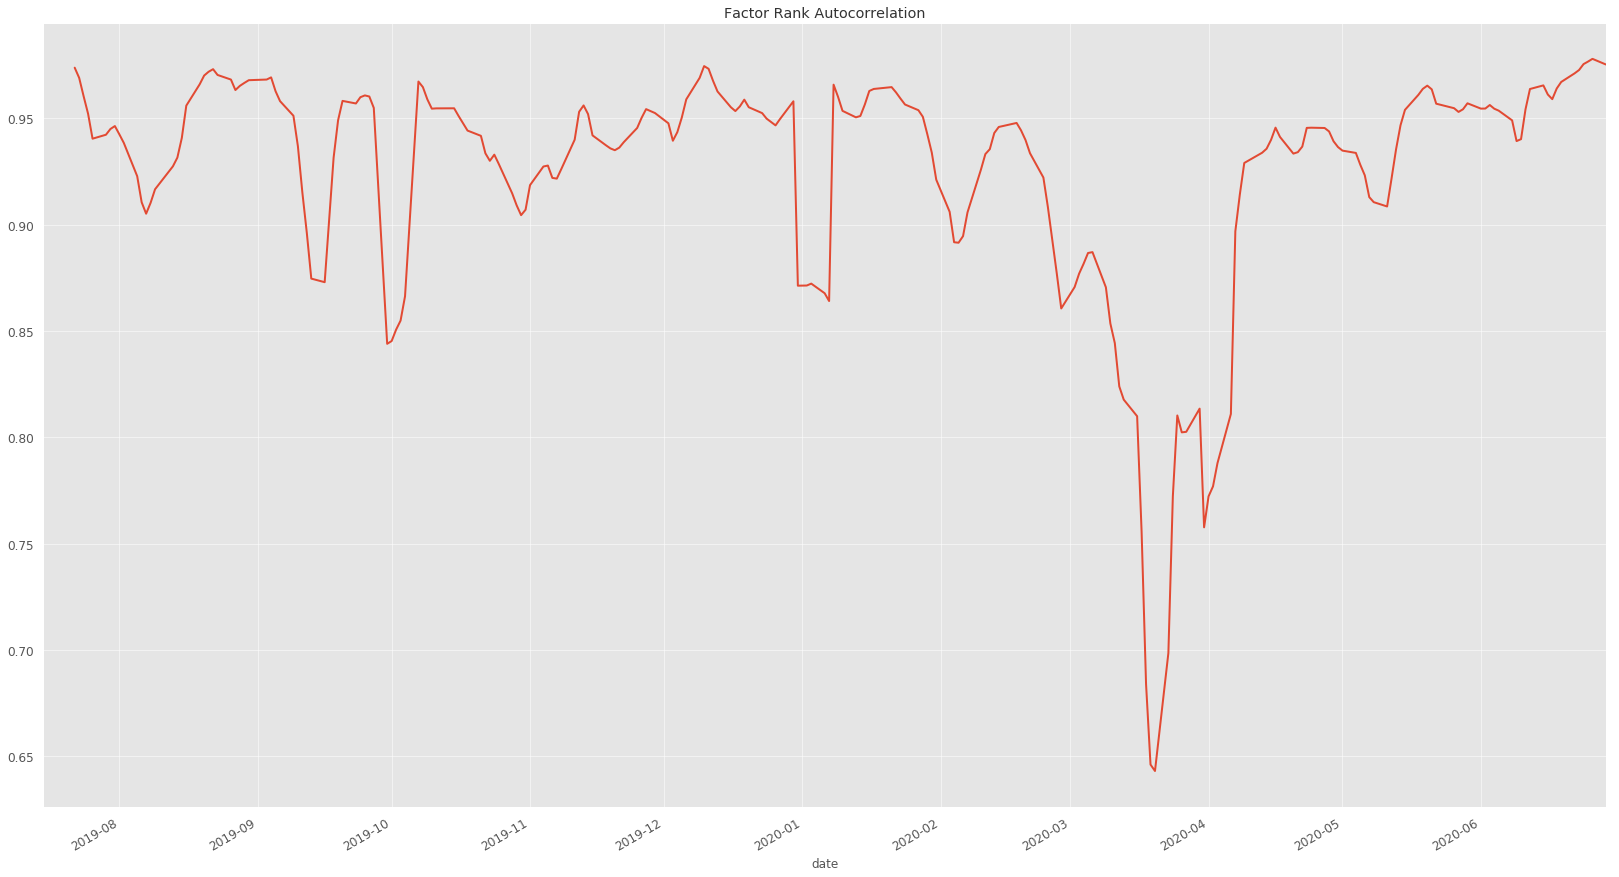

In [96]:
ls_FRA = pd.DataFrame()
ls_FRA = al.performance.factor_rank_autocorrelation(factor_data, period = rebalance_period)
ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

In [97]:
ls_FRA.mean()

0.9240186570018754

In [98]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

3D      5.09
5D      6.45
10D    10.42
dtype: float64

# 7 -  Risk Analysis for Equal Weights

In [99]:
assets = all_factors.index.levels[1]

In [100]:
all_weights = pd.DataFrame(np.repeat(1/len(assets), len(assets)), assets)

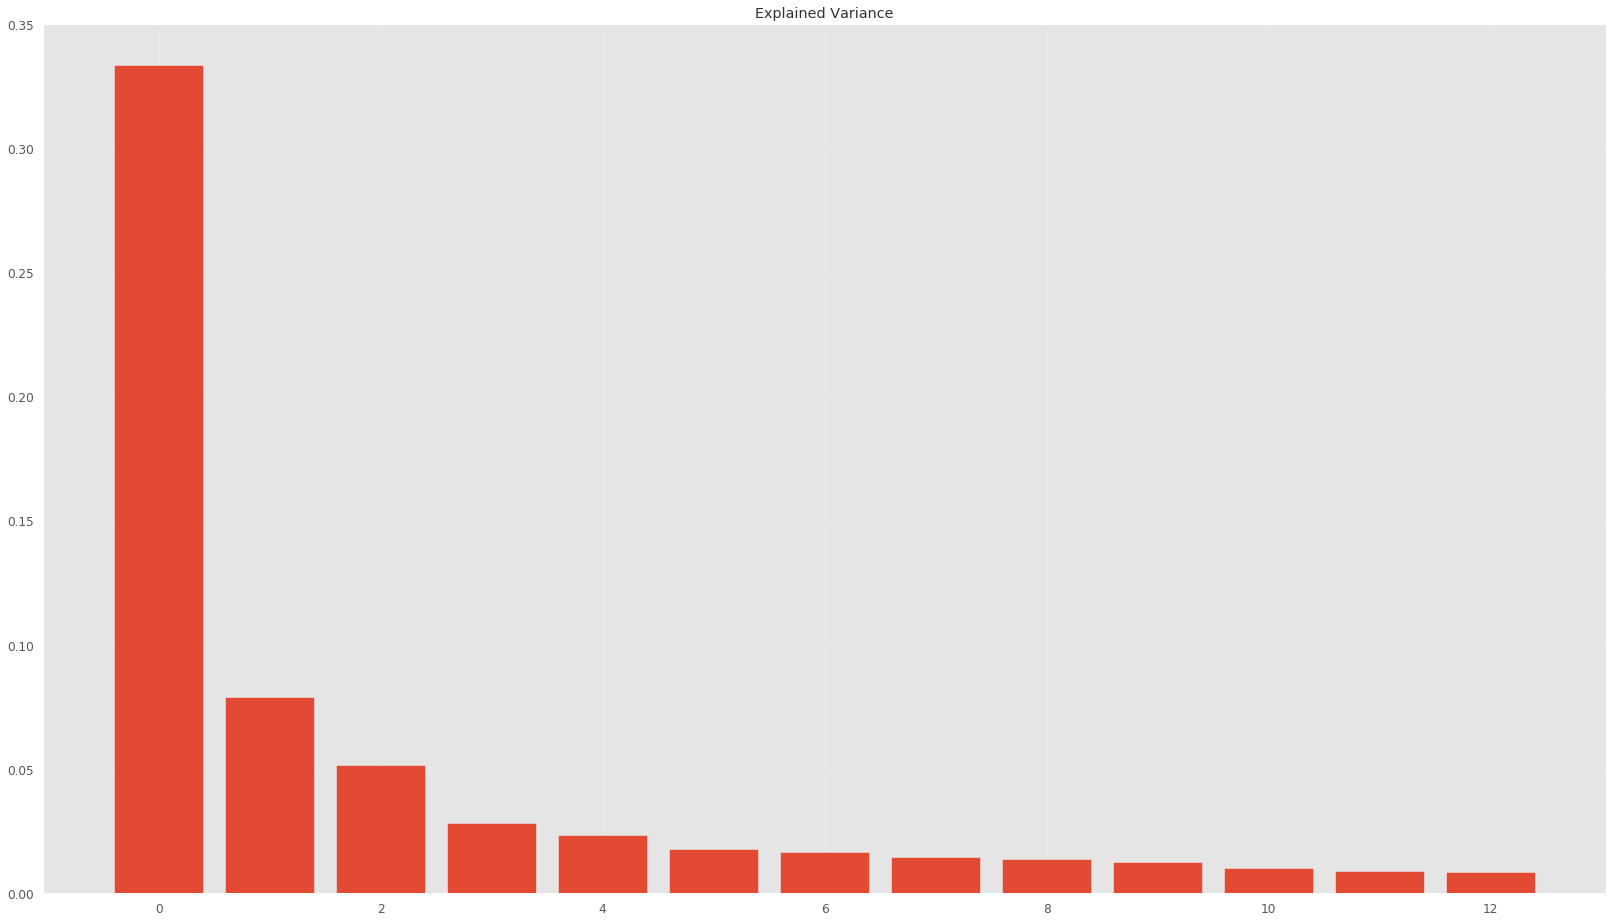

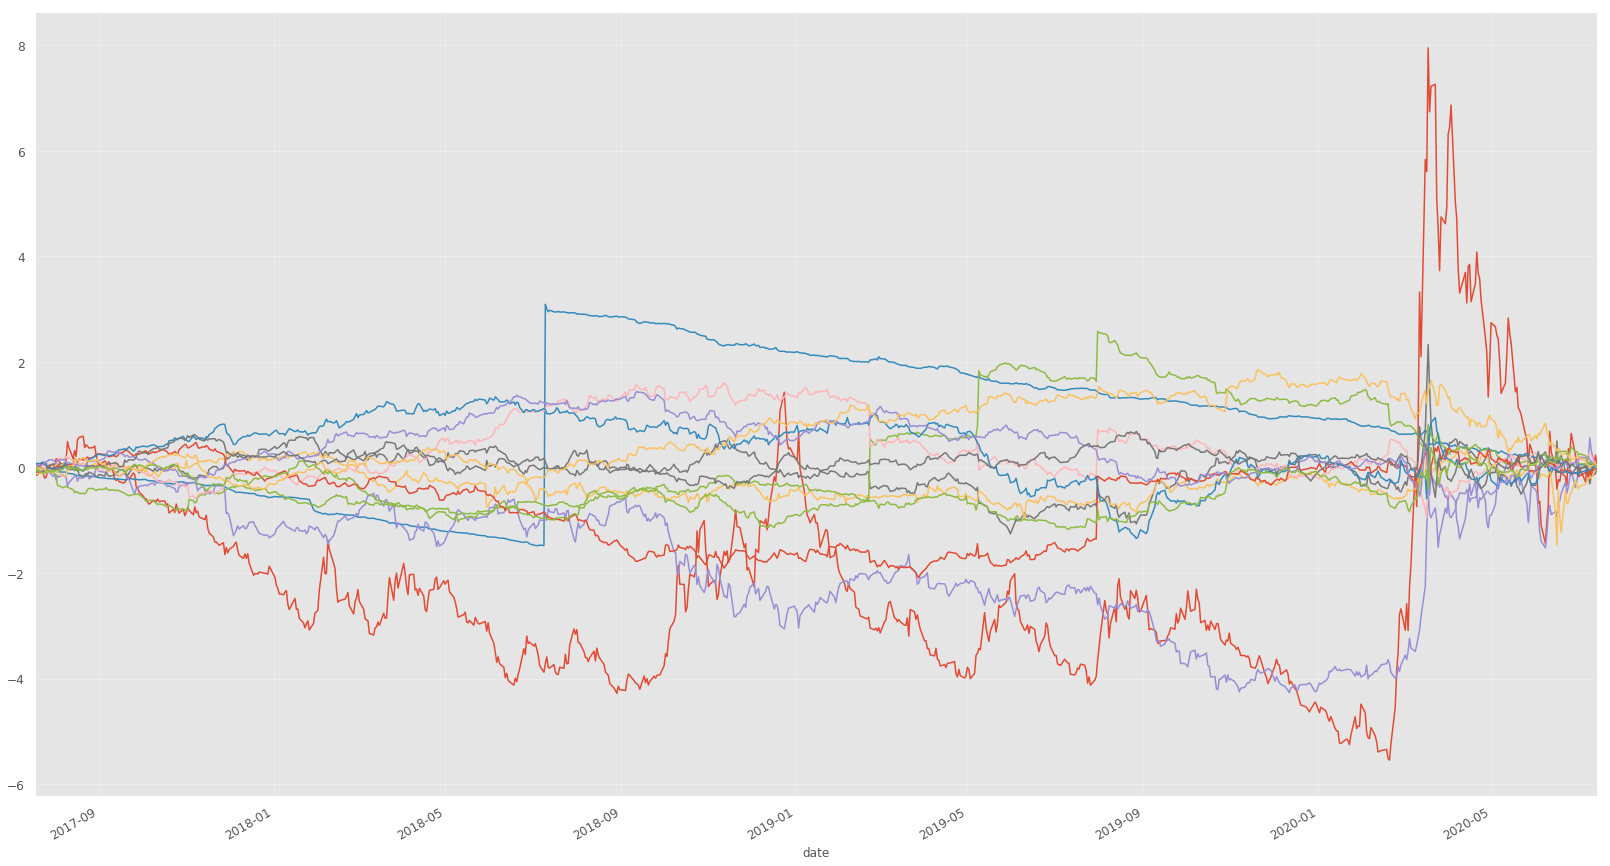

In [101]:
predicted_portfolio_risk,Risk_Model = risk_model.portfolio_risk(close[assets],
                                                                num_factor_exposures=13,
                                                                weights=all_weights)

In [102]:
print ('Predicted Risk: {} %'.format(np.round((predicted_portfolio_risk*100),2)))

Predicted Risk: 26.71 %


# 9 - Integrating optimzer to factor data

In [103]:
optimal = pd.DataFrame(index = all_factors.index.levels[0], columns = all_factors.index.levels[1])
for date in all_factors.index.levels[0]:
    
    x = all_factors[['alpha_vector']].loc[date.date(),:]
    optimal.loc[date] = risk_model\
                          .OptimalHoldingsRegularization(lambda_reg = lambda_reg,
                                                         risk_cap = risk_cap).find(
                                                            x, 
                                                            Risk_Model['factor_betas'], 
                                                            Risk_Model['factor_cov_matrix'], 
                                                            Risk_Model['idiosyncratic_var_vector']).values.flatten()
    

    
optimal = optimal.astype(np.float)
optimal_stacked = optimal.stack().to_frame('optimal_weights')

In [104]:
assert optimal_stacked.shape[0] == vec.shape[0]

## Quantilize data

In [105]:
quantile_optimal_stacked = pd.DataFrame(index = optimal_stacked.index, 
                                        columns = ['optimal_weights','quantile','sector'])
qunatiles = np.linspace(0,1,qunatile_portions+1)
labels = [i+1 for i in range(len(qunatiles)-1)]

for date in optimal_stacked.index.levels[0]:
    
    x = optimal_stacked['optimal_weights'].loc[date.date(),:]
    
    quantile_optimal_stacked.loc[date,'quantile'] = pd.qcut(x, qunatiles, 
                                                            labels = labels)
    
quantile_optimal_stacked.loc[:,'optimal_weights'] = optimal_stacked['optimal_weights']
quantile_optimal_stacked.loc[:,'sector'] = vec['sector']

In [106]:
quantile_optimal_stacked.shape

(94622, 3)

In [107]:
try:
    q_list = []
    for i in qunatile_to_analysis:
        q_list.append((quantile_optimal_stacked['quantile'] == i))

    df_merge = q_list[0]
    for df in q_list[1:]:       
        df_merge = df_merge ^ df
    
    q_final_vector = quantile_optimal_stacked[df_merge]
    
except:
    
    q_final_vector = quantile_optimal_stacked

In [108]:
remaining_quantiles = list(set(q_final_vector.loc[:,'quantile'].values))

In [109]:
rows = q_final_vector.shape[0]

## Sector Selection

In [110]:
try:
    drop_rows_list = []
    for i in drop_long_sec:
        drop_rows_list.append((q_final_vector.sector == i) & (q_final_vector['quantile'] == labels[-1]))

    for i in drop_short_sec:
        drop_rows_list.append((q_final_vector.sector == i) & (q_final_vector['quantile'] == labels[0]))

    if len(drop_rows_list) == 1:
        df_merge = drop_rows_list[0]
    else:
        df_merge = drop_rows_list[0]
        
        for df in drop_rows_list[1:]:       
            df_merge = df_merge ^ df

    final_vector = q_final_vector[~df_merge]
    sectors = final_vector['sector']
    
    assert list(final_vector[(final_vector['quantile'] == labels[-1]) & (final_vector['sector'] == drop_long_sec[0])].values) == []
    assert list(final_vector[(final_vector['quantile'] == labels[0]) & (final_vector['sector'] == drop_short_sec[0])].values) == []

except:
    final_vector = q_final_vector
    sectors = final_vector['sector']

In [111]:
print ('{} rows dropped from final vector'.format(rows - final_vector.shape[0]))

0 rows dropped from final vector


## Balancing to long/short leverage target

In [112]:
for date in final_vector.index.levels[0]:
    
    long_balance = np.abs(final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']>0].sum())
    short_balance = np.abs(final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']<0].sum())
    
    long_ratio = percent_long_leverage_target / long_balance
    short_ratio = percent_short_leverage_target / short_balance

    final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']>0] = final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']>0] * long_ratio
    final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']<0] = final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']<0] * short_ratio

## 9 - 2 - Creating clean factor data

In [113]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor = final_vector['optimal_weights'], 
                                                          prices = pricing, 
                                                          periods = combined_periods,
                                                          quantiles = len(remaining_quantiles),
                                                          groupby=sectors,
                                                          binning_by_group=False,
                                                          filter_zscore=20,
                                                          max_loss=0.15)

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 15.0%, not exceeded: OK!


In [114]:
rows = factor_data.shape[0]

In [115]:
# Sector Selection
try:
    drop_rows_list = []
    for i in drop_long_sec:
        drop_rows_list.append((factor_data.group == i) & (factor_data['factor_quantile'] == 2))

    for i in drop_short_sec:
        drop_rows_list.append((factor_data.group == i) & (factor_data['factor_quantile'] == 1))
    
    if len(drop_rows_list) == 1:
        df_merge = drop_rows_list[0]
    else:
        df_merge = drop_rows_list[0]
        
        for df in drop_rows_list[1:]:       
            df_merge = df_merge ^ df

    factor_data = factor_data[~df_merge]
    sectors = factor_data['group']
    
except:
    
    sectors = factor_data['group']

In [116]:
print ('{} rows dropped from factor data'.format(rows - factor_data.shape[0]))

0 rows dropped from factor data


## 9 - 3 - Creating tear sheets 

In [117]:
pf_returns, pf_positions, pf_benchmark = \
al.performance.create_pyfolio_input(factor_data,
                                   period= '{}D'.format(rebalance_period),
                                   capital=1,
                                   long_short=True,
                                   group_neutral=False,
                                   equal_weight=False,
                                   groups=sectors,
                                   #quantiles=[1,5],
                                   benchmark_period='{}D'.format(rebalance_period))

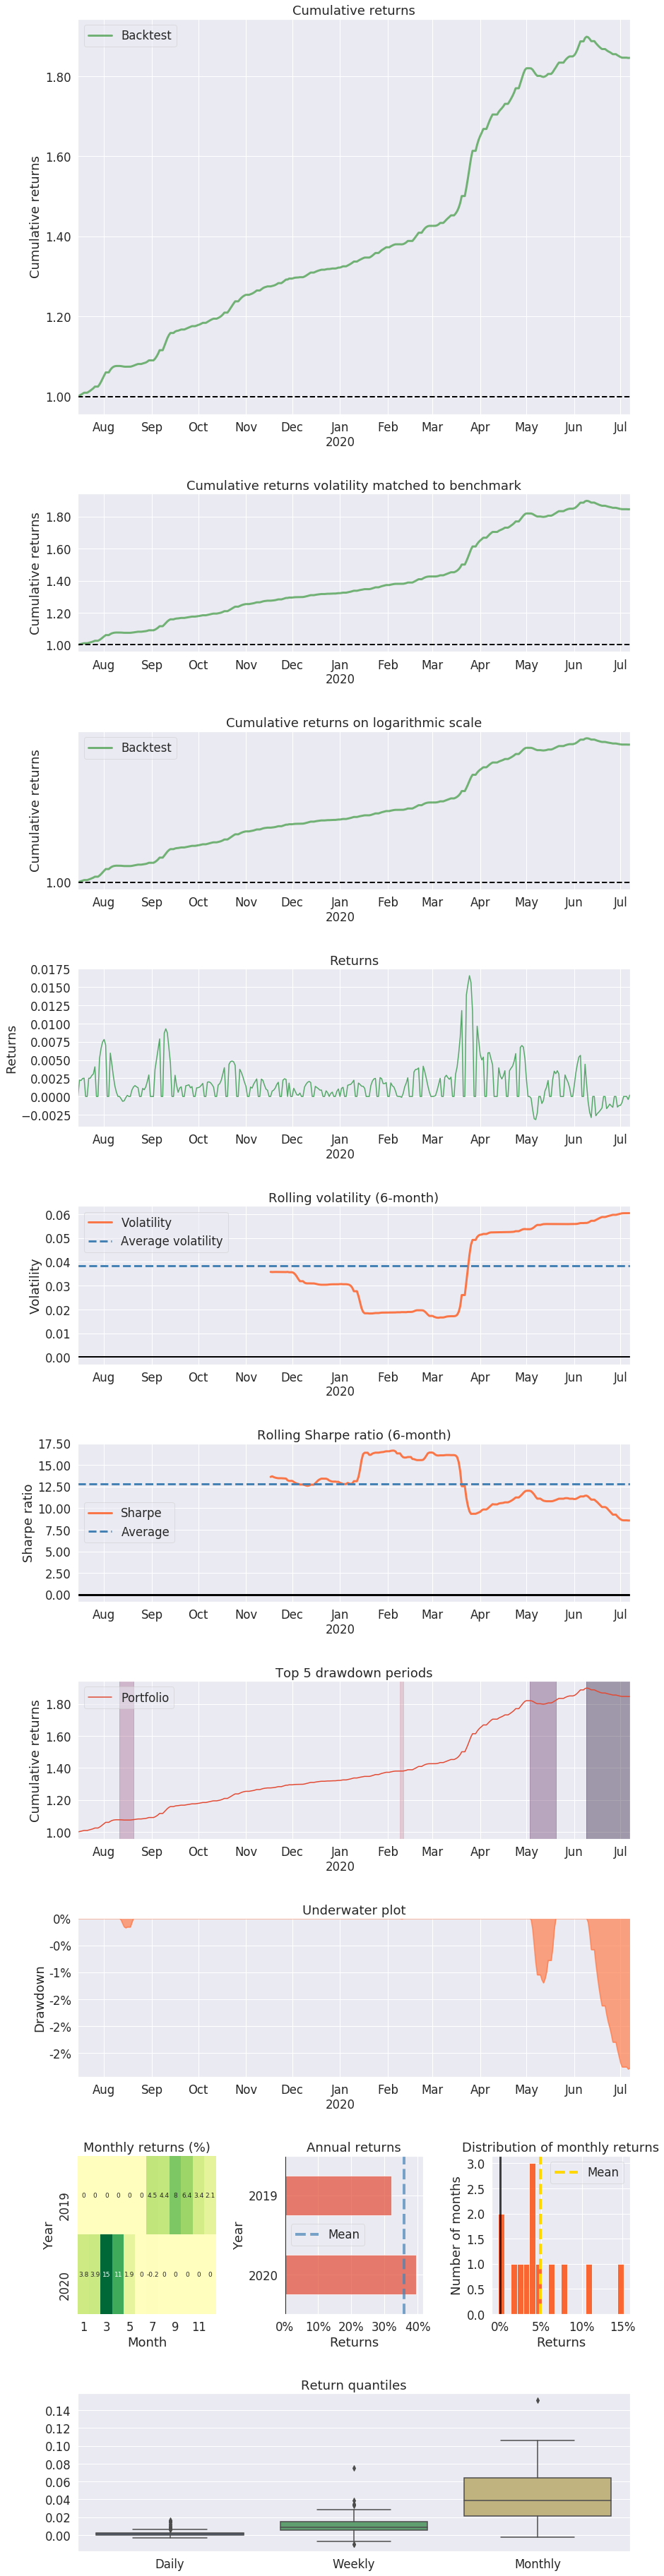

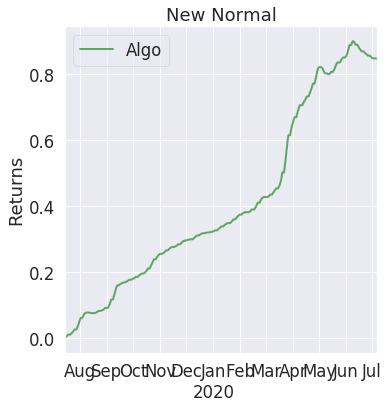

In [118]:
pf.create_full_tear_sheet(pf_returns)

Quantiles Statistics


min           max      mean       std  count  count %
factor_quantile                                                            
1               -0.160494 -1.351266e-09 -0.026667  0.021645   3645     50.0
2                0.004722  2.777506e-01  0.040000  0.032362   3645     50.0

Returns Analysis


3D       5D      10D
Ann. alpha                                       0.841    0.839    0.721
beta                                             0.121    0.111    0.068
Mean Period Wise Return Top Quantile (bps)      77.269   75.545   63.655
Mean Period Wise Return Bottom Quantile (bps)  -77.269  -75.927  -64.615
Mean Period Wise Spread (bps)                  154.539  151.508  128.325

<Figure size 2016x1152 with 0 Axes>

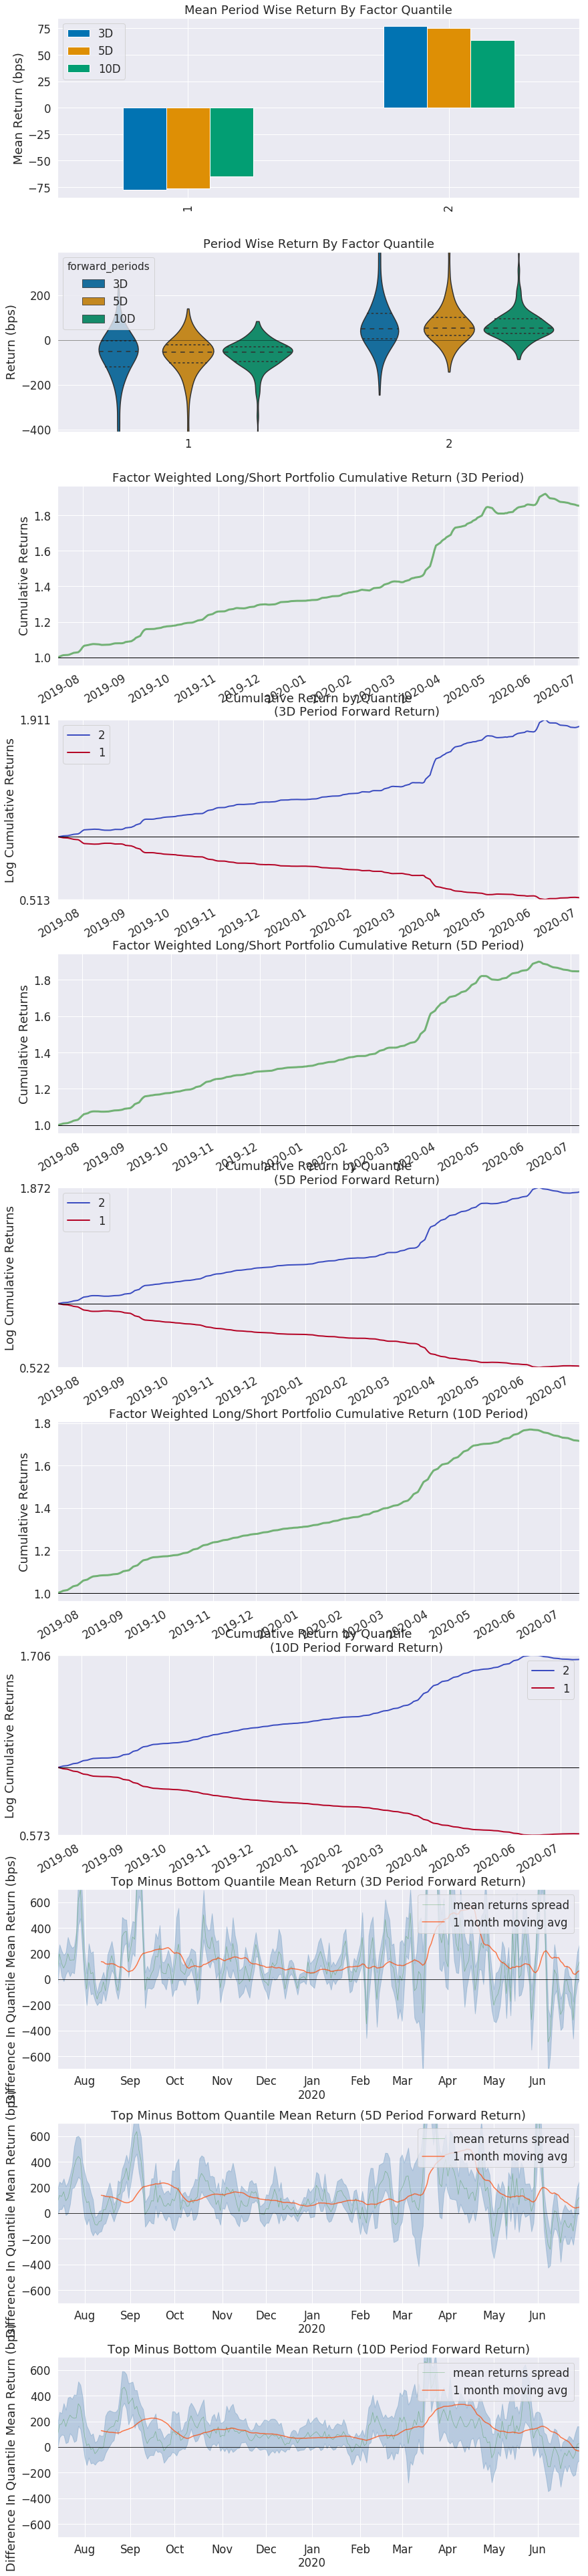

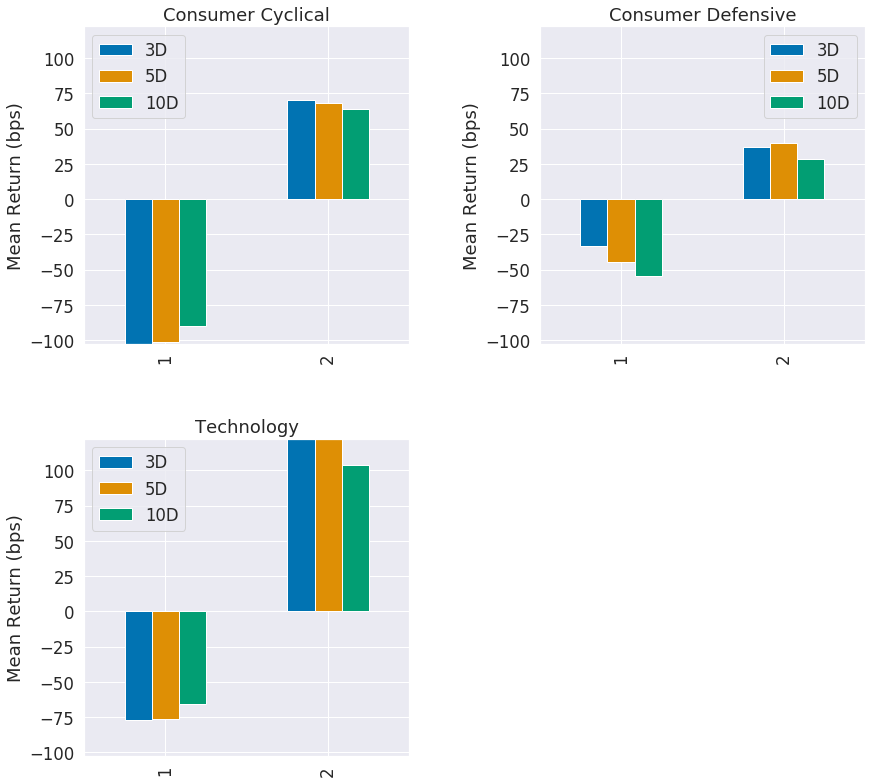

Information Analysis


3D      5D     10D
IC Mean           0.131   0.186   0.262
IC Std.           0.229   0.231   0.241
Risk-Adjusted IC  0.573   0.804   1.091
t-stat(IC)        8.927  12.533  17.011
p-value(IC)       0.000   0.000   0.000
IC Skew           0.013   0.032  -0.284
IC Kurtosis       0.052  -0.109  -0.224

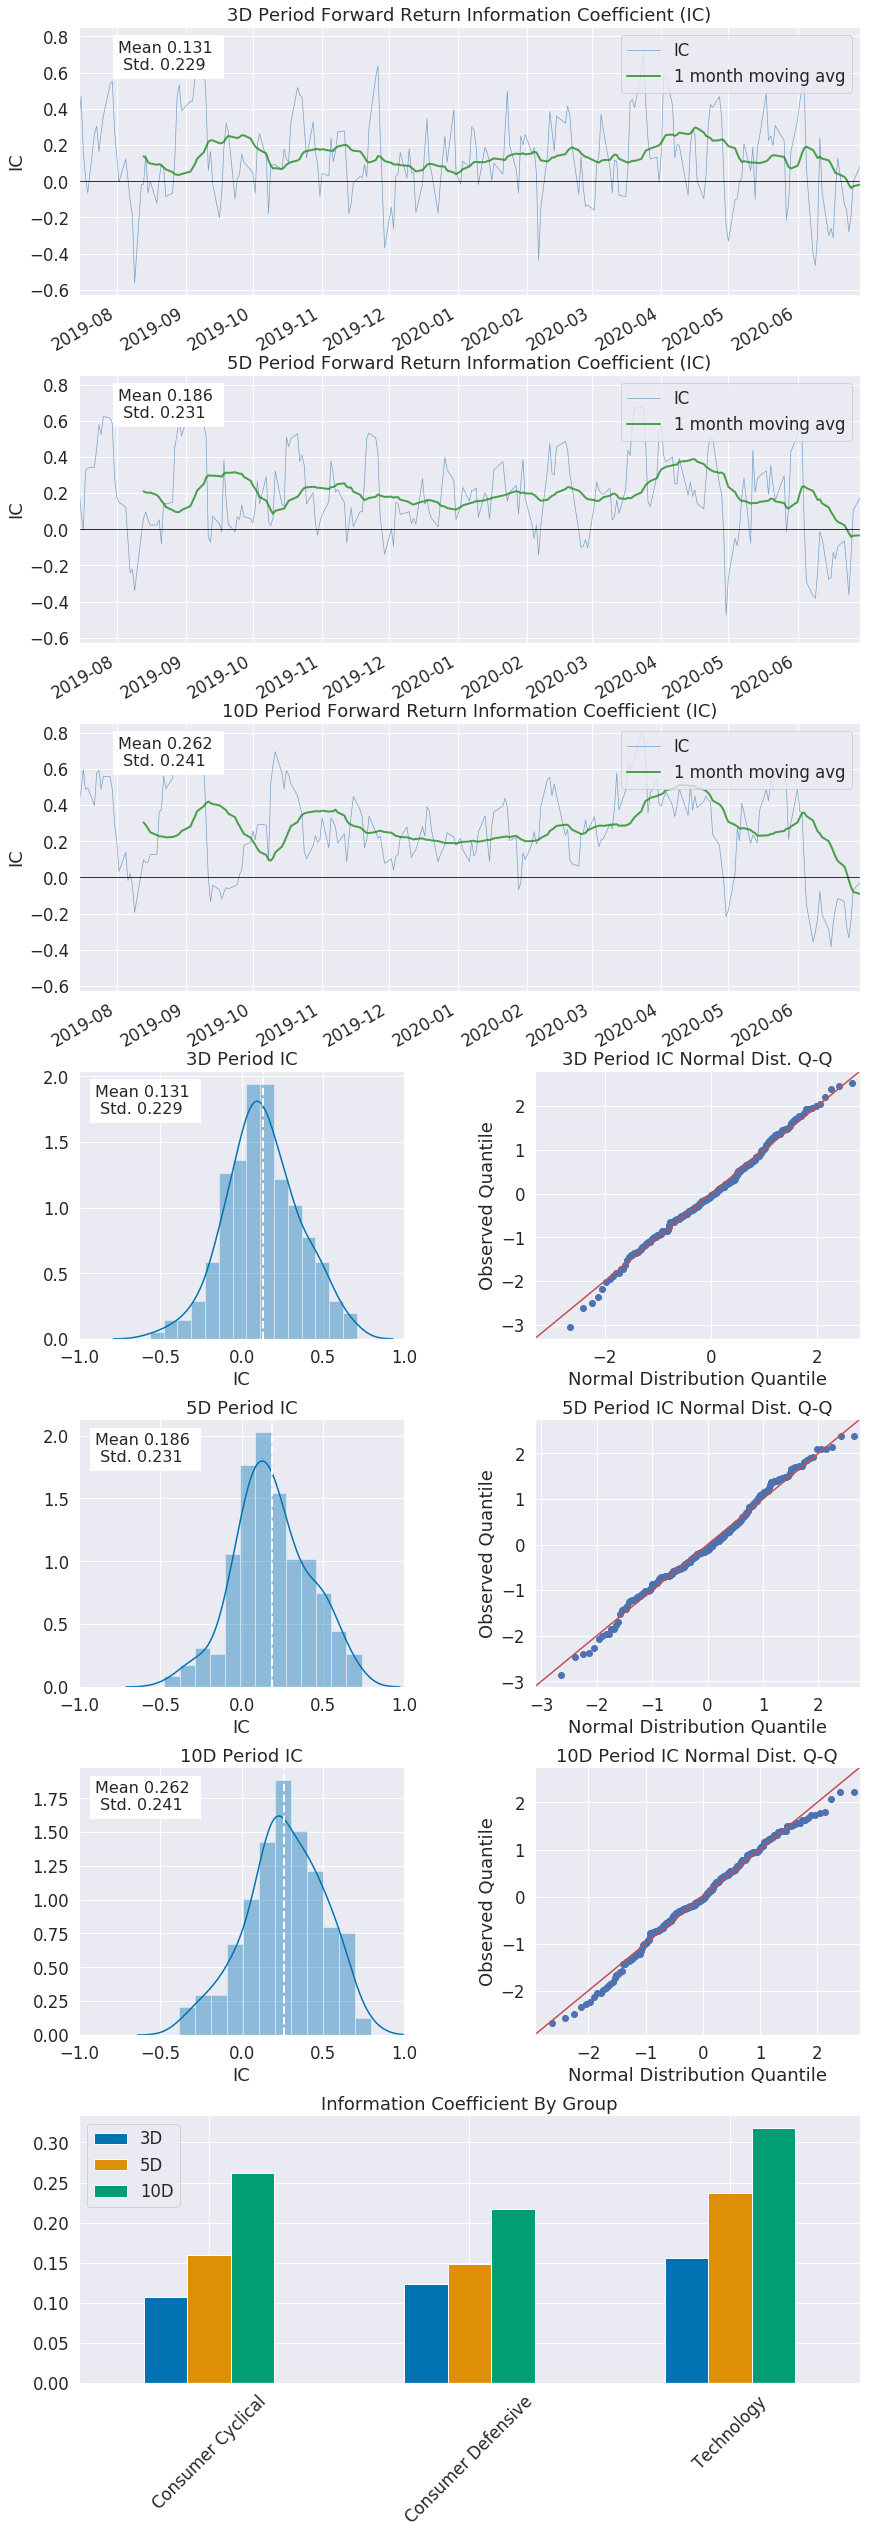

Turnover Analysis


10D     3D     5D
Quantile 1 Mean Turnover   0.510  0.235  0.344
Quantile 2 Mean Turnover   0.498  0.236  0.342

3D     5D    10D
Mean Factor Rank Autocorrelation  0.94  0.919  0.895

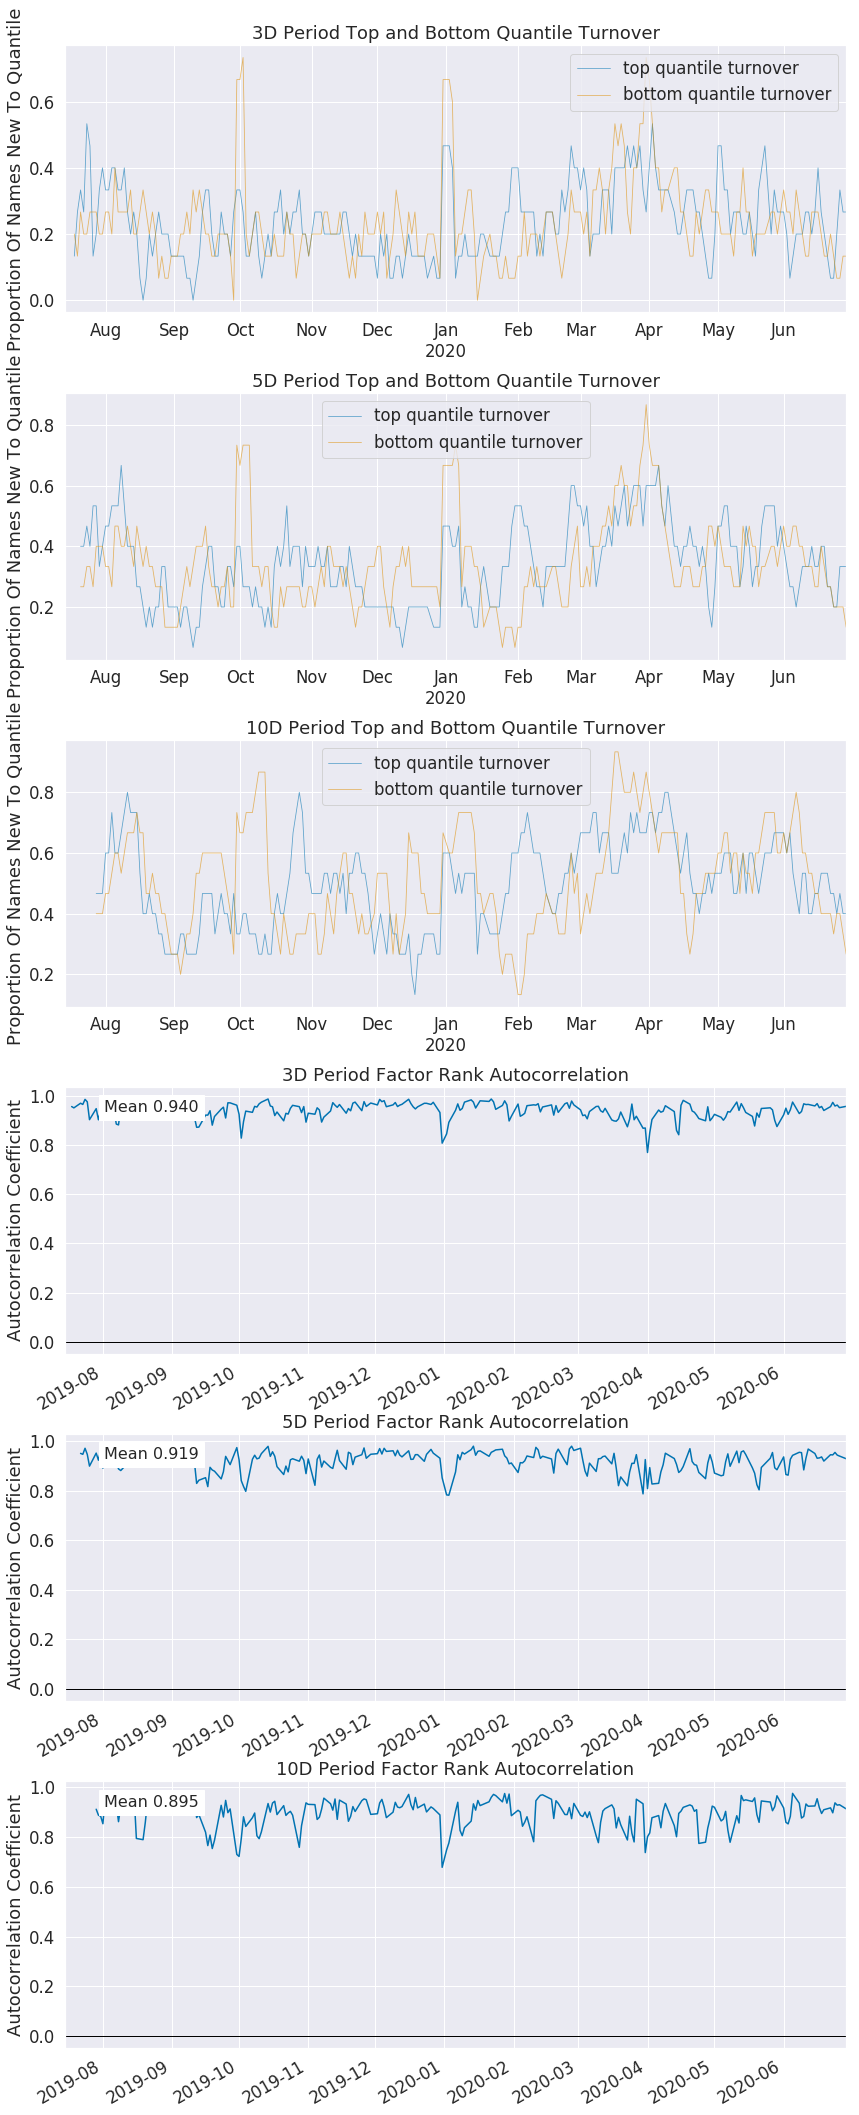

In [119]:
al.tears.create_full_tear_sheet(factor_data, by_group=True, long_short=True, group_neutral=False);

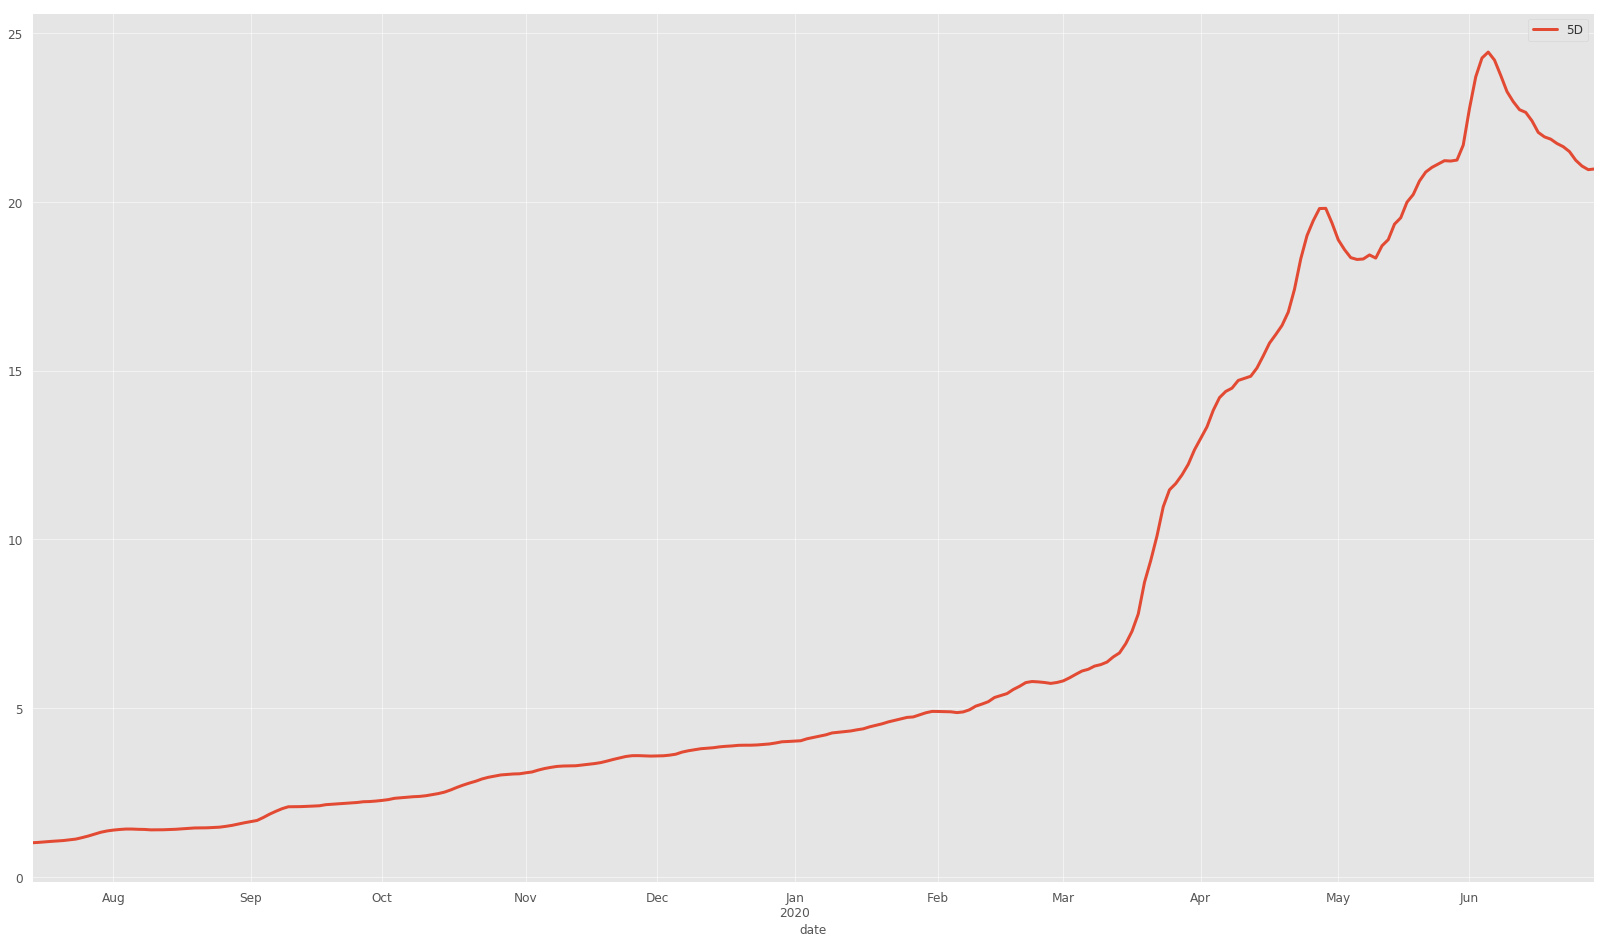

In [120]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (28, 16)

ls_factor_returns = al.performance.factor_returns(factor_data[['factor','5D']])

(1+ls_factor_returns).cumprod().plot(lw=3);

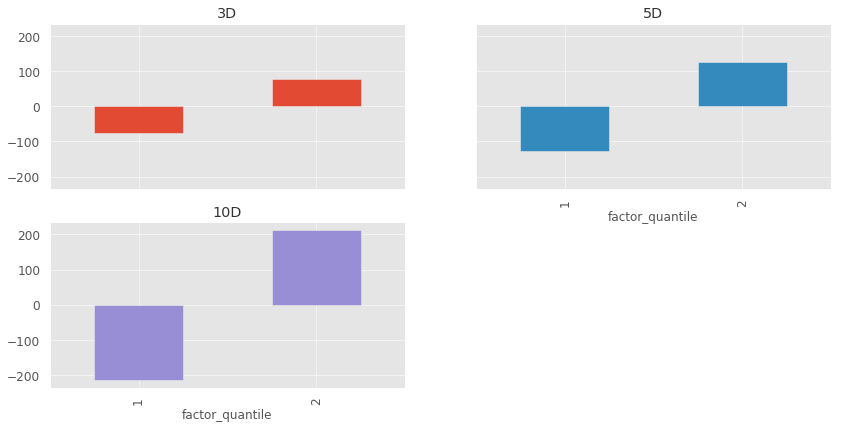

In [121]:
qr_factor_returns = pd.DataFrame()

qr_factor_returns = al.performance.mean_return_by_quantile(factor_data)[0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);

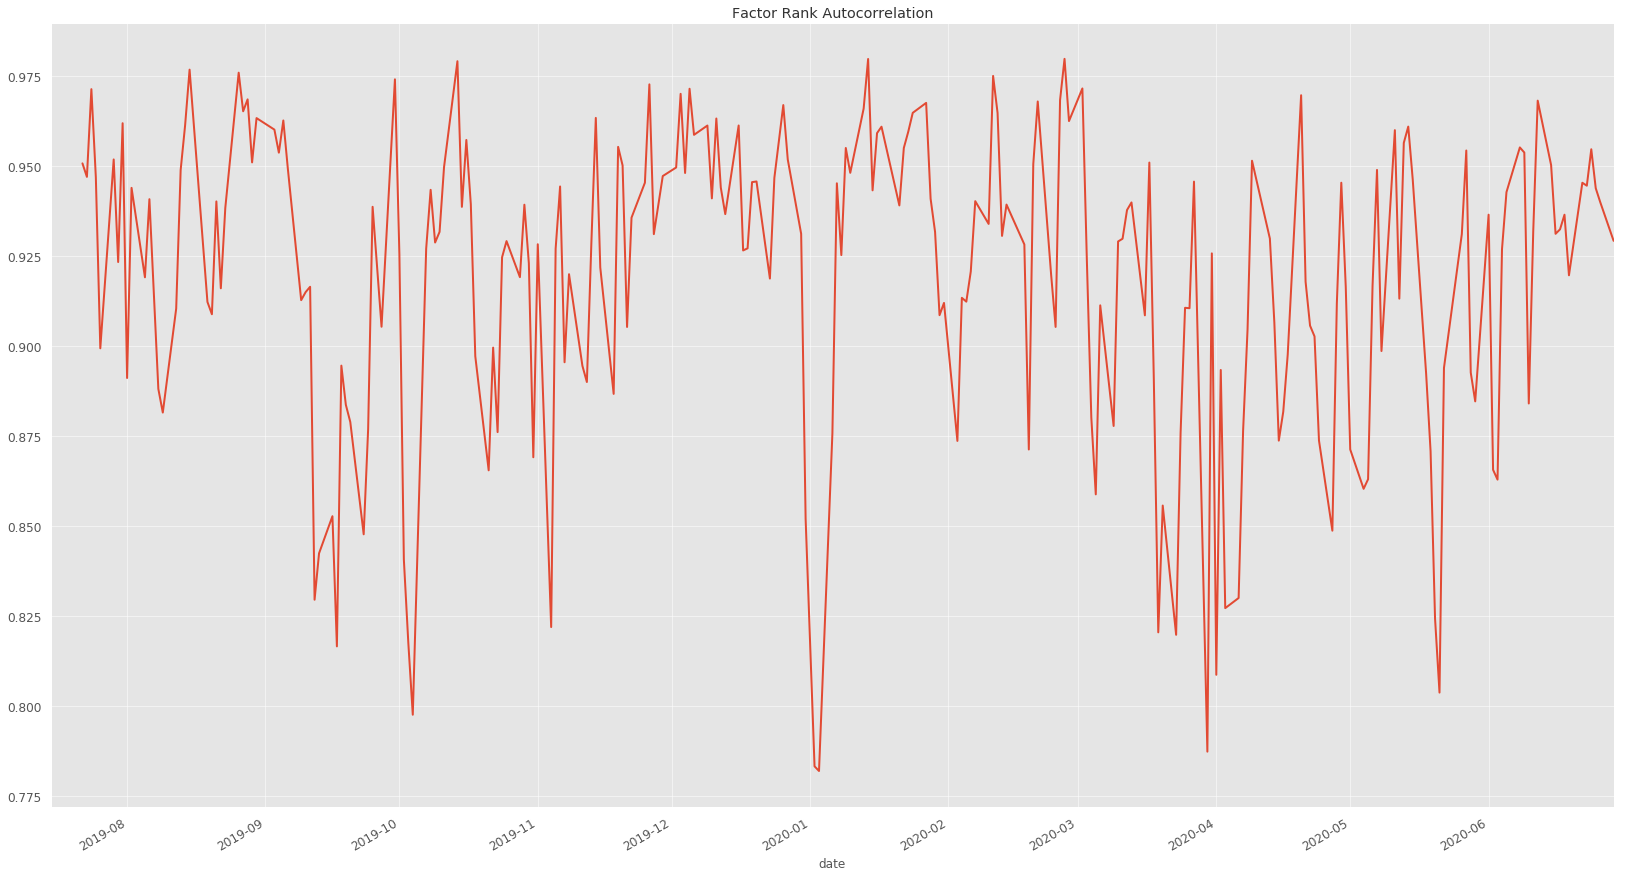

In [122]:
ls_FRA = pd.DataFrame()
ls_FRA = al.performance.factor_rank_autocorrelation(factor_data, period = rebalance_period)
ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

In [123]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

5D    11.54
dtype: float64

# 10 - Predicted Portfolio

In [124]:
optimal_weights_regularized = final_vector[['optimal_weights']].loc[final_vector.index.levels[0][-1]]

for 30 assets  with end date: 2020-07-14 00:00:00+00:00


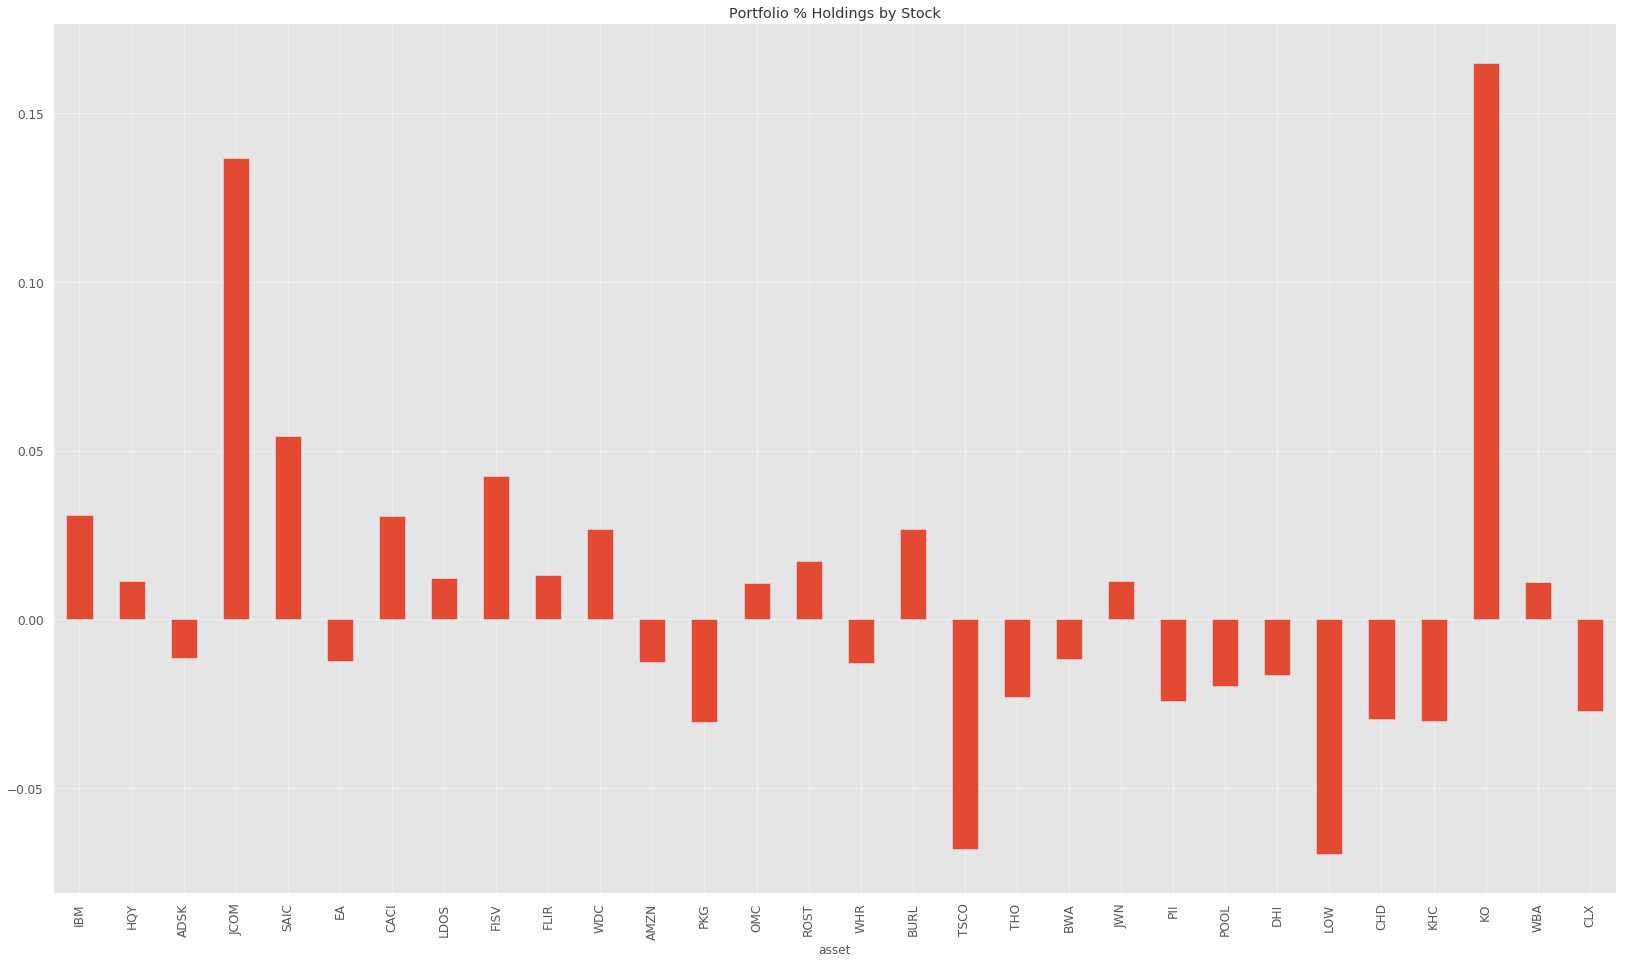

In [125]:
print ('for {} assets  with end date: {}'.format(len(optimal_weights_regularized.index),optimal.index[-1]))
optimal_weights_regularized.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
plt.grid(alpha=0.8)

In [126]:
optimal_weights_regularized = pd.DataFrame(data = optimal_weights_regularized.values, 
                                           columns = ['optimal_weights'],
                                           index = optimal_weights_regularized.index)
optimal_weights_regularized.index.name = 'asset'

In [127]:
q5 = optimal_weights_regularized.sort_values(by='optimal_weights',ascending=False)[:len(optimal_weights_regularized.index)//5]
q1 = optimal_weights_regularized.sort_values(by='optimal_weights',ascending=True)[:len(optimal_weights_regularized.index)//5]

In [128]:
print (q5.iloc[0])
print (q1.iloc[0])

optimal_weights    0.164917
Name: KO, dtype: float64
optimal_weights   -0.069526
Name: LOW, dtype: float64


## 10 - 3 - Risk analysis with optimized weights

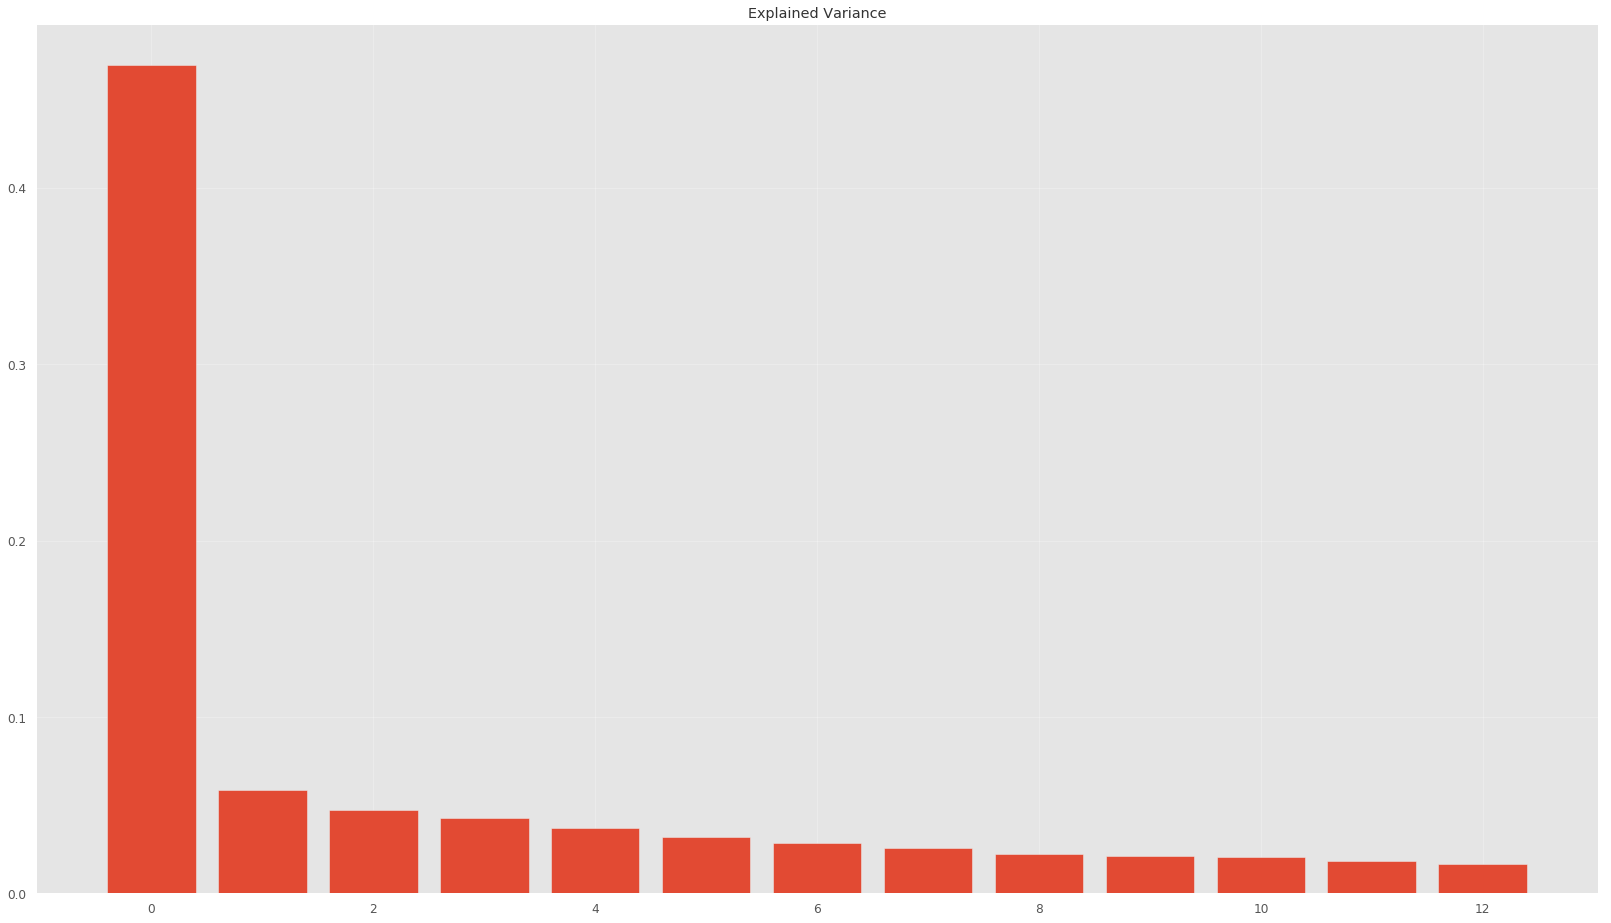

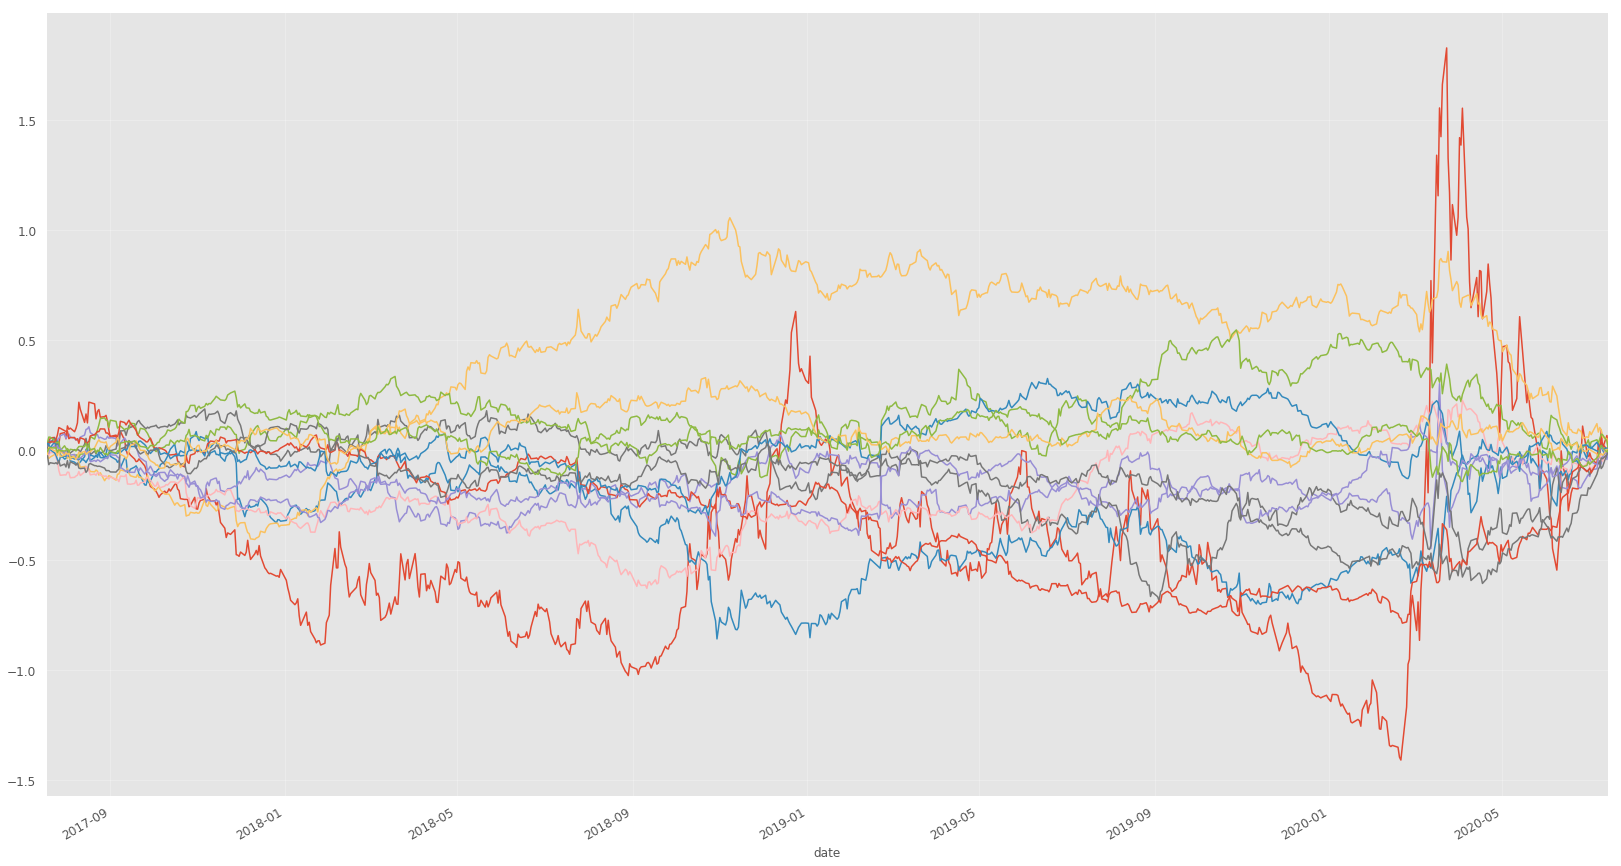

In [129]:
predicted_portfolio_risk,Risk_Model = risk_model.portfolio_risk(close[optimal_weights_regularized.index],num_factor_exposures=factor_exposures,weights=optimal_weights_regularized)

In [130]:
print ('Predicted Risk: {} %'.format(np.round((predicted_portfolio_risk*100),2)))

Predicted Risk: 8.21 %


In [131]:
all_factors.to_csv('data/all_factors.csv')
optimal_weights_regularized.to_csv('output/optimal_weights_regularized.csv')
close.to_csv('data/close.csv')